# CTCF L pos & neg (5%) | rle & kmer features

CTCF_L pos & neg motifs
* mokapot
    * res: (238,349)
    * fibers
        * merged: CTCF_100bp_L_5_v2.mokapot.m6a_fiberseq.txt (13,062,453)
        * pos flanking 100bp: CTCF_m6a_fiberseq_L_100bp_positive-cleaned_100bp.txt (9,495,739)
        * neg flanking 100bp: CTCF_m6a_fiberseq_L_100bp_small_5_negative-cleaned_100bp.txt (8,040,195)
* feature files
    * pin: CTCF_m6a_fiberseq_L_100bp_features-v2.pin (569,889 motif-query combined)
    * pos: CTCF_m6a_fiberseq_L_100bp_positive_features-v2.txt (238,349 motif-query)
    * neg: CTCF_m6a_fiberseq_L_100bp_small_5_negative_features-v2.txt (331,543 motif-query)
* fiberseq files:
    * pos: CTCF_m6a_fiberseq_L_100bp_positive.txt (12,739,713 observations)
    * neg: CTCF_m6a_fiberseq_L_100bp_small_5_negative.txt (39,485,335 observations)

In [2]:
library(ggplot2)
library(data.table)
library(plyr)
library(dplyr)
library(tictoc)
library(ggsci)
library(purrr)
library(scales)
library(stringr)
library(cowplot)
library(gridExtra)
library(tidyr)

In [3]:
while (!is.null(dev.list()))  dev.off()
rm(list=ls())

#------------ Helper Functions ------------
# Initiate PDF
openPDF <- function (output_file_fh, pdf_dims) {
  print(sprintf("Saving plots to: %s", output_file_fh))
  # Open PDF
  pdf(output_file_fh, width = pdf_dims[1], height = pdf_dims[2],
      useDingbats=FALSE, family = "ArialMT")
}

# Close PDF
closePDF <- function () {
  while (!is.null(dev.list()))  dev.off()
  print("File saved.")
}

In [4]:
#------------ Define dirs ------------
setwd("/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting")

#ARGS
data_folder <- sprintf("%s/candidate_footprints", getwd())
mokapot_dir <- sprintf("%s/mokapot_res", getwd())
output_folder <- sprintf("%s/figures", mokapot_dir)

## formatting data

In [5]:
# set args
motif_type <- "L"
input_file_root <- "100bp_L_5_v2"
file_root <- "100bp_L_rle_kmer" # for output file & titles
ctcf_dist <- c(-100,100)
n_rows <- Inf

# load set data file
data_file_name <- sprintf("CTCF_%s.mokapot.m6a_fiberseq.txt", input_file_root)
data_file <- sprintf("%s/%s", mokapot_dir, data_file_name)
print(data_file)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/CTCF_100bp_L_5_v2.mokapot.m6a_fiberseq.txt"


In [6]:
# read table
df <- fread(data_file, nrows=n_rows)
sprintf("m6a rows: %s", format(dim(df)[1], big.mark=",", scientific=FALSE))

# filter centered_position_type for m6a
df <- filter(df, centered_position_type == "m6a")
sprintf("m6a rows: %s", format(dim(df)[1], big.mark=",", scientific=FALSE))

[1] "m6a rows: 17,535,934"

[1] "m6a rows: 17,535,934"

In [6]:
df <- df %>%
    mutate(Label = ifelse(Label == 1, "Positive", "Negative"))

table(df$Label)


Negative Positive 
 8040195  9495739 

In [7]:
df$FDR_05 <- ifelse(df$FDR < 0.05, "low_FDR", "high_FDR")
df$FDR_01 <- ifelse(df$FDR < 0.01, "low_FDR", "high_FDR")
df$FDR_001 <- ifelse(df$FDR < 0.001, "low_FDR", "high_FDR")
df$FDR_0001 <- ifelse(df$FDR < 0.0001, "low_FDR", "high_FDR")

In [8]:
table(df$FDR_05)
table(df$FDR_01)
table(df$FDR_001)
table(df$FDR_0001)


high_FDR  low_FDR 
 8734847  8801087 


high_FDR  low_FDR 
10314245  7221689 


high_FDR  low_FDR 
13839002  3696932 


high_FDR  low_FDR 
15823979  1711955 

In [10]:
# unique CTCF motifs, queries, & motif_queries
sprintf("unique motifs: %s", format(length(unique(df$motif_name)), big.mark=",", scientific=FALSE))
sprintf("unique queries: %s", format(length(unique(df$query_name)), big.mark=",", scientific=FALSE))
sprintf("unique motif-query groups: %s", format(length(unique(df$motif_query)), big.mark=",", scientific=FALSE))

[1] "unique motifs: 260,946"

[1] "unique queries: 411,235"

[1] "unique motif-query groups: 569,891"

In [11]:
df_og <- df

In [12]:
table(df$Label)


Negative Positive 
 8040195  9495739 

## plot & color parameters

In [9]:
# change plot dimensions
options(repr.plot.width=20, repr.plot.height=10)

set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }
set_plot_dimensions(15, 7.5)

In [10]:
# create density plot
font_size <- 12
font_info <- element_text(size=font_size, family="ArialMT", color="black")

In [11]:
# define colors (light grey, purple, darker grey, blue)
vline_col <- "#CECDCC"
m6a_col <- "#7F3F98"
fiber_col <- "#D1D2D4"
motif_annot_col <- "#006738"#"#6C9272"#"blue"

# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")

## m6a fiberseq density plots

### grouped pos & neg sets

In [ ]:
#------------ Set output file ------------
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_fiberseq_density-all.pdf", file_root)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- TRUE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.m6a_fiberseq_density-all.pdf"


In [ ]:
# get plot max
density(df$centered_start)
max(density(df$centered_start)$y)


Call:
	density.default(x = df$centered_start)

Data: df$centered_start (17535934 obs.);	Bandwidth 'bw' = 1.521

       x                 y            
 Min.   :-104.56   Min.   :4.778e-06  
 1st Qu.: -52.28   1st Qu.:3.059e-03  
 Median :   0.00   Median :5.098e-03  
 Mean   :   0.00   Mean   :4.777e-03  
 3rd Qu.:  52.28   3rd Qu.:6.751e-03  
 Max.   : 104.56   Max.   :8.417e-03  

[1] 0.008417369

In [ ]:
# create density plot
font_size <- 12
font_info <- element_text(size=font_size, family="ArialMT", color="black")

plot_title <- sprintf("CTCF m6a density merged pos & neg data\n%s | feature type(s): rle & kmers | m6As: %s", 
                      "Pos & 5% L neg", format(nrow(df), big.mark=",", scientific=FALSE))
x_axis_name <- "distance from CTCF start (bp)"
y_axis_name <- "aggregate m6a methylation density"

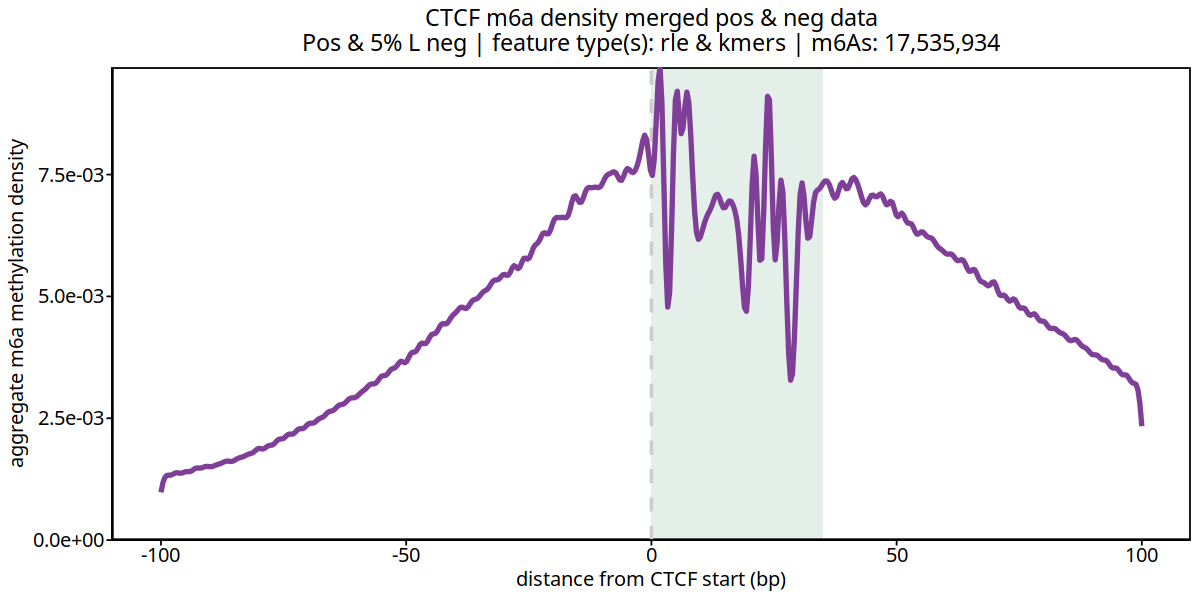

In [ ]:
# define colors (light grey, purple, darker grey, blue)
vline_col <- "#CECDCC"
m6a_col <- "#7F3F98"
fiber_col <- "#D1D2D4"
# light green
motif_annot_col <- "#006738"#"#6C9272"#"blue"
# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# neg, high m6A & no TF: blue | pos, no m6A & TF: red
color_vals <- c(mitch_cols[5], mitch_cols[2])

# set plot size
options(repr.plot.width=pdf_dims[1], repr.plot.height=pdf_dims[2])


p <- ggplot(df, aes(x=centered_start)) +
    # add box over motif location
    annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.1, fill=motif_annot_col) +
    # add vertical line at x=0
    geom_vline(xintercept=0, color=vline_col, show.legend=FALSE, linetype="dashed", linewidth=1) +
    # density plot
    geom_density(col=m6a_col, size=1.5, adjust=0.5) +
    
    ggtitle(plot_title) +
    scale_y_continuous(limits=y_limits, expand=expansion(mult=c(0,0)), name=y_axis_name,
                       labels = function(x) format(x, scientific=TRUE), guide=guide_axis(check.overlap=TRUE)) +
    scale_x_continuous(name=x_axis_name, limits=x_limits) +
    theme_classic() +
    theme(text = font_info,
          axis.ticks = element_line(color="#000000", lineend="square"),
          axis.text = font_info,
          panel.background = element_rect(fill="transparent", color="#000000", size=1),
          plot.title = element_text(family="ArialMT", size=font_size+2, hjust=0.5))
p

if (save_pdf == TRUE) {
    ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])
}

__postitive vs negative__

In [ ]:
#------------ Set output file ------------
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_fiberseq_density-pos_v_neg.pdf", file_root)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- TRUE
pdf_dims <- c(10,5)
     

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.m6a_fiberseq_density-pos_v_neg.pdf"


In [ ]:
# set y-lim
y_limits <- c(0, NA)#round_any(max(density(df$centered_start)$y)*1.2, 0.001, f=ceiling))
x_limits <- c(-100, 100)

plot_title <- sprintf("CTCF m6a density pos vs negative sets\n%s | rle & kmers | m6A pos: %s | m6A neg: %s", 
                      "Pos & 5% L neg",
                      format(table(df$Label)["Positive"], big.mark=",", scientific=FALSE), 
                      format(table(df$Label)["Negative"], big.mark=",", scientific=FALSE))
x_axis_name <- "distance from CTCF start (bp)"
y_axis_name <- "aggregate m6a methylation density"

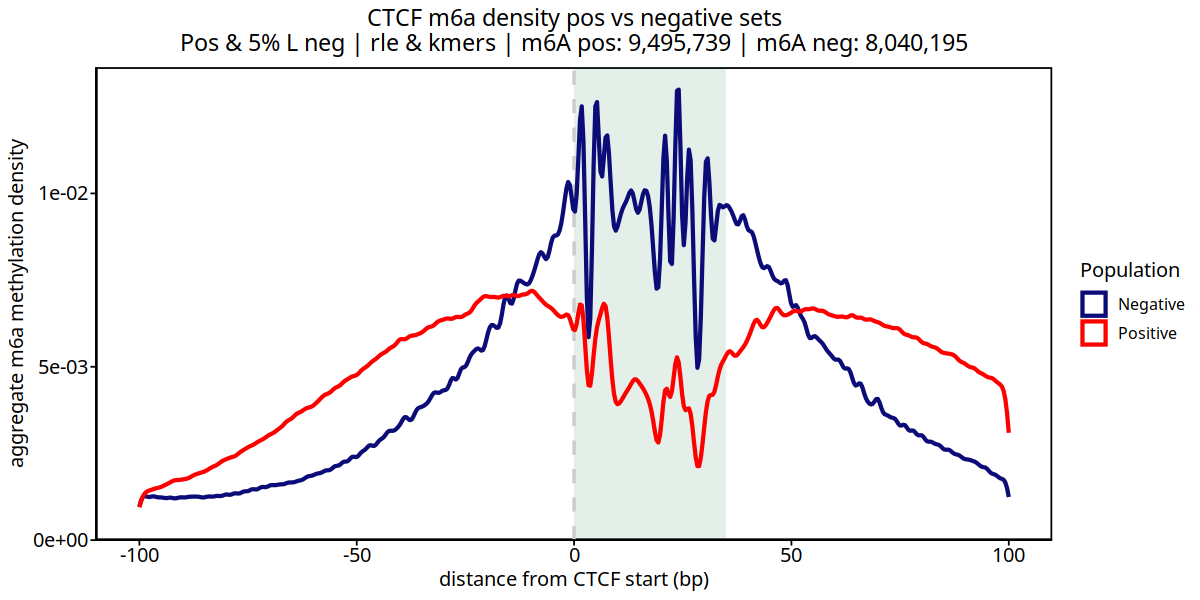

In [ ]:
# define colors (light grey, purple, darker grey, blue)
vline_col <- "#CECDCC"
m6a_col <- "#7F3F98"
fiber_col <- "#D1D2D4"
# light green
motif_annot_col <- "#006738"#"#6C9272"#"blue"
# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# neg, high m6A & no TF: blue | pos, no m6A & TF: red
color_vals <- c(mitch_cols[5], mitch_cols[2])

# set plot size
options(repr.plot.width=pdf_dims[1], repr.plot.height=pdf_dims[2])

p <- ggplot(df, aes(x=centered_start, group=Label)) +
    # add box over motif location
    annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.1, fill=motif_annot_col) +
    # add vertical line at x=0
    geom_vline(xintercept=0, color="#CECDCC", show.legend=FALSE, linetype="dashed", linewidth=1) +
    # density plot
    geom_density(aes(col=Label), size=1.2, adjust=0.5) +
    # red, blue
    scale_color_manual(name="Population", values=color_vals, labels=c("Negative", "Positive")) +
    scale_y_continuous(limits=c(0, NA), expand=expansion(mult=c(0,0.05)), name=y_axis_name,
                       labels = function(x) format(x, scientific=TRUE), guide=guide_axis(check.overlap=TRUE)) +
    
    ggtitle(plot_title) +
    scale_x_continuous(name=x_axis_name) +
    theme_classic() +
    theme(text = font_info,
          axis.ticks = element_line(color="#000000", lineend="square"),
          axis.text = font_info,
          panel.background = element_rect(fill="transparent", color="#000000", size=1),
          plot.title = element_text(family="ArialMT", size=font_size+2, hjust=0.5))
p

if (save_pdf == TRUE) {
    ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])
}

### Pos data (FDR filt)

In [ ]:
#------------ Set output file ------------
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_fiberseq_density-pos_FDR.pdf", file_root)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file?
save_pdf <- FALSE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.m6a_fiberseq_density-pos_FDR.pdf"


In [ ]:
# filter for positive data
pos <- df[df$Label == "Positive"]

In [ ]:
FDR_cols <- c("FDR_05", "FDR_01", "FDR_001", "FDR_0001")

__FDR < 0.05__

In [ ]:
#------------ Set output file ------------
FDR <- 0.05
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_fiberseq_density-pos_FDR_%s.pdf", file_root, FDR)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file?
save_pdf <- TRUE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.m6a_fiberseq_density-pos_FDR_0.05.pdf"


In [ ]:
# set y-lim
y_limits <- c(0, NA)#round_any(max(density(df$centered_start)$y)*1.2, 0.001, f=ceiling))
x_limits <- c(-100, 100)

plot_title <- sprintf("CTCF m6a density pos vs negative sets (FDR < %s)\n%s | rle & kmers | m6A pos: %s | m6A neg: %s", 
                      FDR, "Pos & 5% L neg",
                      format(table(df$FDR_05)["low_FDR"], big.mark=",", scientific=FALSE), 
                      format(table(df$FDR_05)["high_FDR"], big.mark=",", scientific=FALSE))
x_axis_name <- "distance from CTCF start (bp)"
y_axis_name <- "aggregate m6a methylation density"
legend_labels <- c(sprintf("FDR > %s", FDR), sprintf("FDR < %s", FDR))

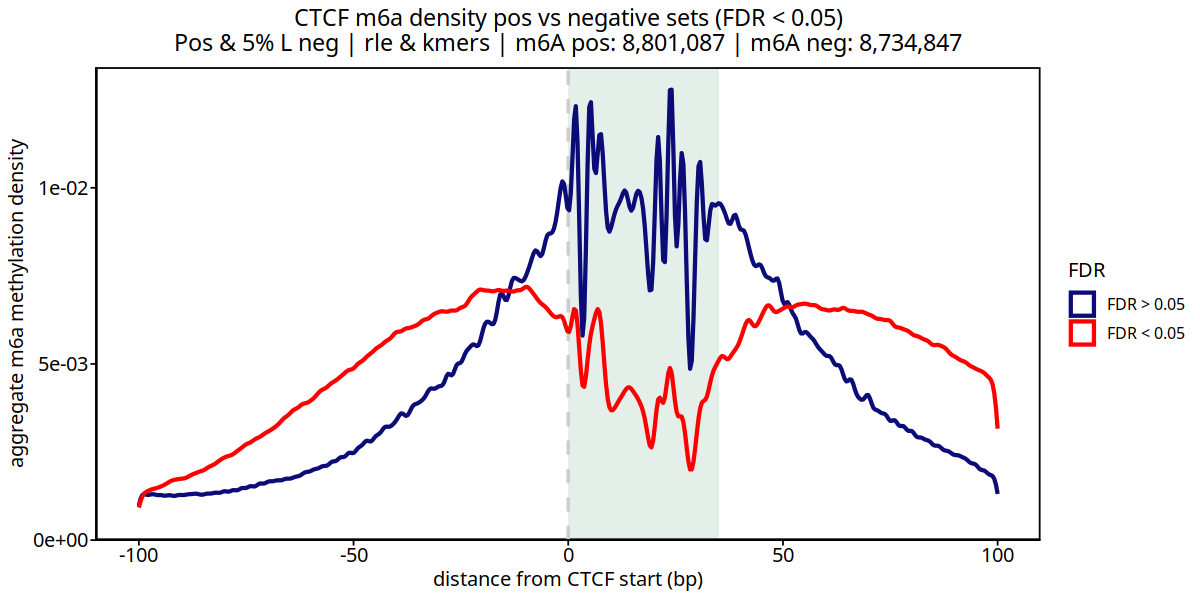

In [ ]:
# define colors (light grey, purple, darker grey, blue)
vline_col <- "#CECDCC"
m6a_col <- "#7F3F98"
fiber_col <- "#D1D2D4"
motif_annot_col <- "#006738"#"#6C9272"#"blue"
# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# neg, high m6A & no TF: blue | pos, no m6A & TF: red
color_vals <- c(mitch_cols[5], mitch_cols[2])

# set plot size
options(repr.plot.width=pdf_dims[1], repr.plot.height=pdf_dims[2])

p <- ggplot(df, aes(x=centered_start, group=FDR_05)) +
    # add box over motif location
    annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.1, fill=motif_annot_col) +
    # add vertical line at x=0
    geom_vline(xintercept=0, color="#CECDCC", show.legend=FALSE, linetype="dashed", linewidth=1) +
    # density plot
    geom_density(aes(col=FDR_05), size=1.2, adjust=0.5) +
    # red, blue
    scale_color_manual(name="FDR", values=color_vals, labels=legend_labels) +
    scale_y_continuous(limits=c(0, NA), expand=expansion(mult=c(0,0.05)), name=y_axis_name,
                       labels = function(x) format(x, scientific=TRUE), guide=guide_axis(check.overlap=TRUE)) +
    
    ggtitle(plot_title) +
    scale_x_continuous(name=x_axis_name) +
    theme_classic() +
    theme(text = font_info,
          axis.ticks = element_line(color="#000000", lineend="square"),
          axis.text = font_info,
          panel.background = element_rect(fill="transparent", color="#000000", size=1),
          plot.title = element_text(family="ArialMT", size=font_size+2, hjust=0.5))
p

if (save_pdf == TRUE) {
    ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])
}

__FDR < 0.01__

In [ ]:
#------------ Set output file ------------
FDR <- 0.01
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_fiberseq_density-pos_FDR_%s.pdf", file_root, FDR)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file?
save_pdf <- TRUE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.m6a_fiberseq_density-pos_FDR_0.01.pdf"


In [ ]:
# set y-lim
y_limits <- c(0, NA)#round_any(max(density(df$centered_start)$y)*1.2, 0.001, f=ceiling))
x_limits <- c(-100, 100)

plot_title <- sprintf("CTCF m6a density pos vs negative sets (FDR < %s)\n%s | rle & kmers | m6A pos: %s | m6A neg: %s", 
                      FDR, "Pos & 5% L neg",
                      format(table(df$FDR_01)["low_FDR"], big.mark=",", scientific=FALSE), 
                      format(table(df$FDR_01)["high_FDR"], big.mark=",", scientific=FALSE))
x_axis_name <- "distance from CTCF start (bp)"
y_axis_name <- "aggregate m6a methylation density"
legend_labels <- c(sprintf("FDR > %s", FDR), sprintf("FDR < %s", FDR))

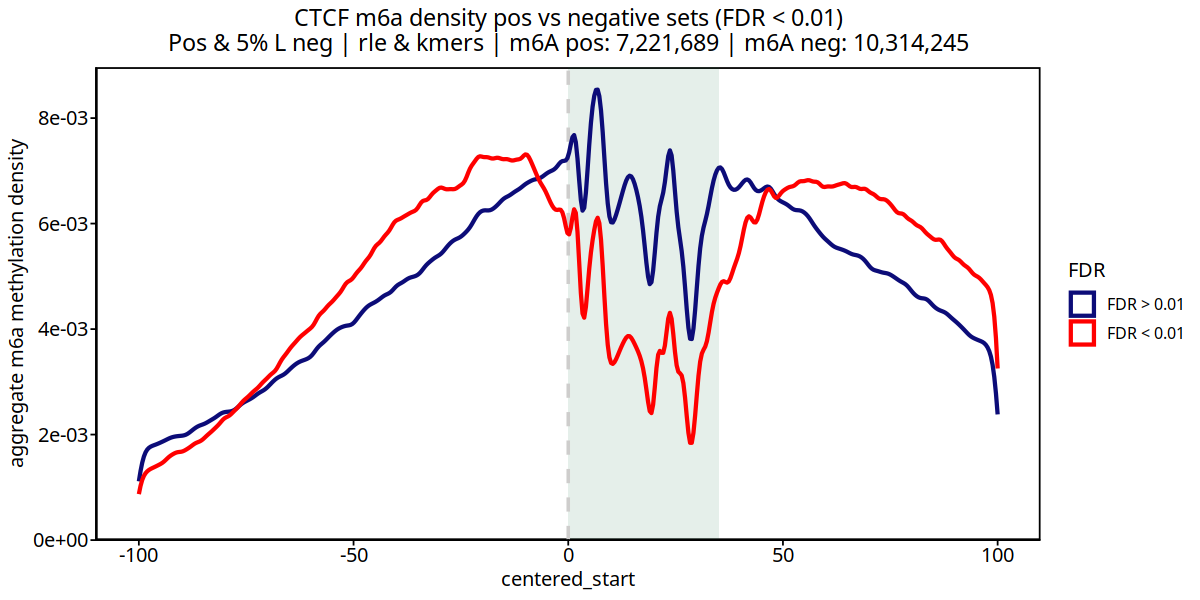

In [ ]:
# define colors (light grey, purple, darker grey, blue)
vline_col <- "#CECDCC"
m6a_col <- "#7F3F98"
fiber_col <- "#D1D2D4"
motif_annot_col <- "#006738"#"#6C9272"#"blue"
# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# neg, high m6A & no TF: blue | pos, no m6A & TF: red
color_vals <- c(mitch_cols[5], mitch_cols[2])

# set plot size
options(repr.plot.width=pdf_dims[1], repr.plot.height=pdf_dims[2])

p <- ggplot(pos, aes(x=centered_start, group=FDR_01)) +
    # add box over motif location
    annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.1, fill=motif_annot_col) +
    # add vertical line at x=0
    geom_vline(xintercept=0, color="#CECDCC", show.legend=FALSE, linetype="dashed", linewidth=1) +
    # density plot
    geom_density(aes(col=FDR_01), size=1.2, adjust=0.5) +
    scale_color_manual(name="FDR", values=color_vals, labels=legend_labels) +
    scale_y_continuous(limits=c(0, NA), expand=expansion(mult=c(0,0.05)), name=y_axis_name,
                       labels = function(x) format(x, scientific=TRUE), guide=guide_axis(check.overlap=TRUE)) +
    
    ggtitle(plot_title) +
    theme_classic() +
    theme(text = font_info,
          axis.ticks = element_line(color="#000000", lineend="square"),
          axis.text = font_info,
          panel.background = element_rect(fill="transparent", color="#000000", size=1),
          plot.title = element_text(family="ArialMT", size=font_size+2, hjust=0.5))
p

if (save_pdf == TRUE) {
    ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])
}

__FDR < 0.001__

In [ ]:
#------------ Set output file ------------
FDR <- 0.001
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_fiberseq_density-pos_FDR_%s.pdf", file_root, FDR)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file?
save_pdf <- TRUE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.m6a_fiberseq_density-pos_FDR_0.001.pdf"


In [ ]:
# set y-lim
y_limits <- c(0, NA)#round_any(max(density(df$centered_start)$y)*1.2, 0.001, f=ceiling))
x_limits <- c(-100, 100)

plot_title <- sprintf("CTCF m6a density pos vs negative sets (FDR < %s)\n%s | rle & kmers | m6A pos: %s | m6A neg: %s", 
                      FDR, "Pos & 5% L neg",
                      format(table(df$FDR_001)["low_FDR"], big.mark=",", scientific=FALSE), 
                      format(table(df$FDR_001)["high_FDR"], big.mark=",", scientific=FALSE))
x_axis_name <- "distance from CTCF start (bp)"
y_axis_name <- "aggregate m6a methylation density"
legend_labels <- c(sprintf("FDR > %s", FDR), sprintf("FDR < %s", FDR))

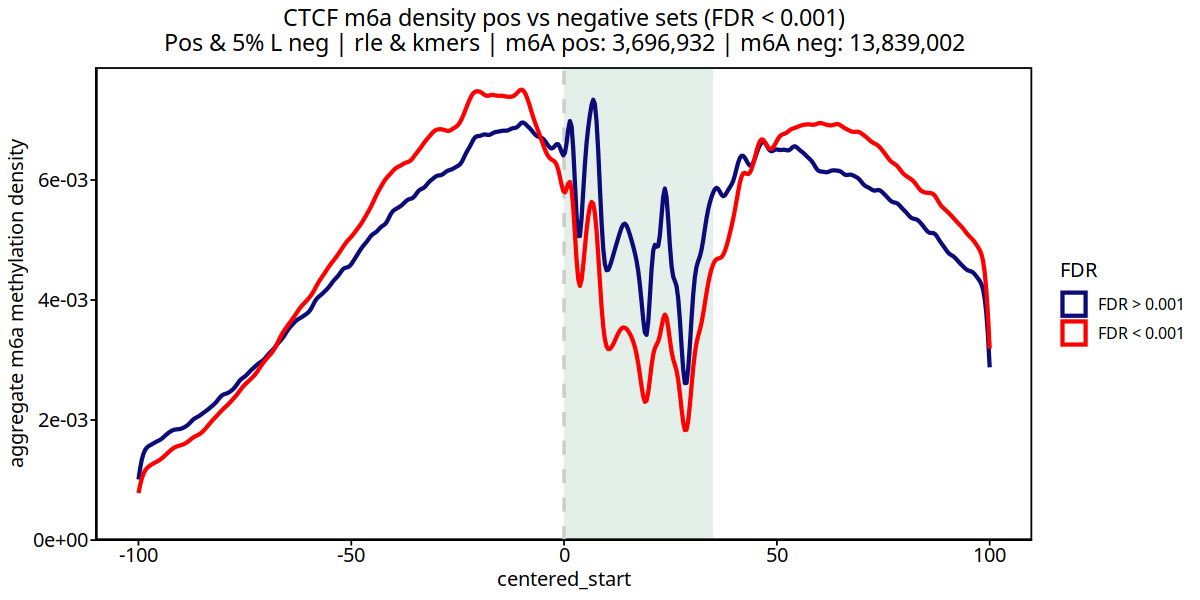

In [ ]:
# define colors (light grey, purple, darker grey, blue)
vline_col <- "#CECDCC"
m6a_col <- "#7F3F98"
fiber_col <- "#D1D2D4"
motif_annot_col <- "#006738"#"#6C9272"#"blue"
# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# neg, high m6A & no TF: blue | pos, no m6A & TF: red
color_vals <- c(mitch_cols[5], mitch_cols[2])

# set plot size
options(repr.plot.width=pdf_dims[1], repr.plot.height=pdf_dims[2])


p <- ggplot(pos, aes(x=centered_start, group=FDR_001)) +
    # add box over motif location
    annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.1, fill=motif_annot_col) +
    # add vertical line at x=0
    geom_vline(xintercept=0, color="#CECDCC", show.legend=FALSE, linetype="dashed", linewidth=1) +
    # density plot
    geom_density(aes(col=FDR_001), size=1.2, adjust=0.5) +
    # red, blue
    scale_color_manual(name="FDR", values=color_vals, labels=legend_labels) +
    scale_y_continuous(limits=c(0, NA), expand=expansion(mult=c(0,0.05)), name=y_axis_name,
                       labels = function(x) format(x, scientific=TRUE), guide=guide_axis(check.overlap=TRUE)) +
    
    ggtitle(plot_title) +
    theme_classic() +
    theme(text = font_info,
          axis.ticks = element_line(color="#000000", lineend="square"),
          axis.text = font_info,
          panel.background = element_rect(fill="transparent", color="#000000", size=1),
          plot.title = element_text(family="ArialMT", size=font_size+2, hjust=0.5))
p

if (save_pdf == TRUE) {
    ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])
}

__FDR < 0.0001__

In [ ]:
#------------ Set output file ------------
FDR <- 0.0001
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_fiberseq_density-pos_FDR_%s.pdf", file_root, FDR)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file?
save_pdf <- TRUE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.m6a_fiberseq_density-pos_FDR_1e-04.pdf"


In [ ]:
# set y-lim
y_limits <- c(0, NA)#round_any(max(density(df$centered_start)$y)*1.2, 0.001, f=ceiling))
x_limits <- c(-100, 100)

plot_title <- sprintf("CTCF m6a density pos vs negative sets (FDR < %s)\n%s | rle & kmers | m6A pos: %s | m6A neg: %s", 
                      FDR, "Pos & 5% L neg",
                      format(table(df$FDR_0001)["low_FDR"], big.mark=",", scientific=FALSE), 
                      format(table(df$FDR_0001)["high_FDR"], big.mark=",", scientific=FALSE))
x_axis_name <- "distance from CTCF start (bp)"
y_axis_name <- "aggregate m6a methylation density"
legend_labels <- c(sprintf("FDR > %s", FDR), sprintf("FDR < %s", FDR))

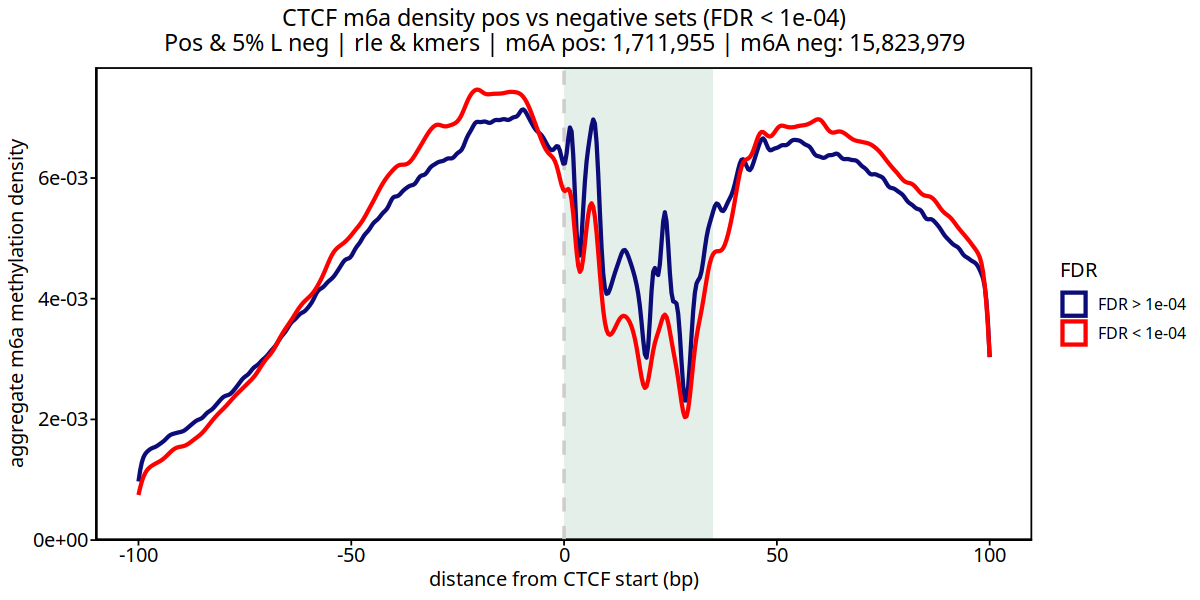

In [ ]:
# define colors (light grey, purple, darker grey, blue)
vline_col <- "#CECDCC"
m6a_col <- "#7F3F98"
fiber_col <- "#D1D2D4"
motif_annot_col <- "#006738"#"#6C9272"#"blue"
# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# neg, high m6A & no TF: blue | pos, no m6A & TF: red
color_vals <- c(mitch_cols[5], mitch_cols[2])

# set plot size
options(repr.plot.width=pdf_dims[1], repr.plot.height=pdf_dims[2])


p <- ggplot(pos, aes(x=centered_start, group=FDR_0001)) +
    # add box over motif location
    annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.1, fill=motif_annot_col) +
    # add vertical line at x=0
    geom_vline(xintercept=0, color="#CECDCC", show.legend=FALSE, linetype="dashed", linewidth=1) +
    # density plot
    geom_density(aes(col=FDR_0001), size=1.2, adjust=0.5) +
    scale_color_manual(name="FDR", values=color_vals, labels=legend_labels) +
    scale_y_continuous(limits=c(0, NA), expand=expansion(mult=c(0,0.05)), name=y_axis_name,
                       labels = function(x) format(x, scientific=TRUE), guide=guide_axis(check.overlap=TRUE)) +
    ggtitle(plot_title) +
    scale_x_continuous(name=x_axis_name) +
    theme_classic() +
    theme(text = font_info,
          axis.ticks = element_line(color="#000000", lineend="square"),
          axis.text = font_info,
          panel.background = element_rect(fill="transparent", color="#000000", size=1),
          plot.title = element_text(family="ArialMT", size=font_size+2, hjust=0.5))
p

if (save_pdf == TRUE) {
    ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])
}

## per fiber m6a plots

In [12]:
# change plot dimensions
options(repr.plot.width=20, repr.plot.height=10)

set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }
set_plot_dimensions(15, 7.5)

In [13]:
res <- df

In [14]:
#------------ Example motif data ------------

# load data file
data_file_name <- "CTCF_m6a_fiberseq_100bp_fig_example_positive.txt"
data_file <- sprintf("%s/%s", data_folder, data_file_name)
print(data_file)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/candidate_footprints/CTCF_m6a_fiberseq_100bp_fig_example_positive.txt"


In [15]:
# read table
df <- fread(data_file)
dim(df)

[1] 2165   13

In [16]:
# add motif_name row
df$motif_name <- paste(df$chrom, df$centering_position, df$strand, sep="_")
# move motif_name to first column
df <- df %>%
    select("motif_name", everything())

# add motif_query column
df <- cbind(paste(df$motif_name, df$query_name, sep="/"), df)
# rename column
colnames(df)[1] = "motif_query"

In [17]:
# get only m6a
df <- df[df$centered_position_type %in% c("m6a")]
# filter our rows with N in sequence
df <- df %>% filter(!(grepl("N", subset_sequence)))

In [18]:
# get moka res for motif-query values in example
moka <- filter(res, motif_query %in% df$motif_query)
dim(moka)

[1] 1829   22

In [19]:
# get max rle per fiber
#ARGS
feature_dir <- sprintf("%s/feature_data", getwd())

# load set data file
data_file_name <- "CTCF_m6a_fiberseq_L_100bp_features-rle-max.pin"
data_file <- sprintf("%s/%s", feature_dir, data_file_name)
print(data_file)

# read table
df_f <- fread(data_file, nrows=n_rows)
sprintf("m6a rows: %s", format(dim(df_f)[1], big.mark=",", scientific=FALSE))

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/feature_data/CTCF_m6a_fiberseq_L_100bp_features-rle-max.pin"


[1] "m6a rows: 569,891"

In [20]:
# add max rle to table w/ FDRs
names(df_f)[names(df_f) == "SpecID"] <- "motif_query"
moka <- merge(moka, df_f[,c("motif_query", "rle_max")], by="motif_query")

In [21]:
# plot m6a instances in coords
motif_coords <- c("chr20", 63786415, 63786450)

#### purple (unsorted)

In [40]:
#------------ Set output file ------------
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_per_fiber_uncolored_sorted.pdf", file_root)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- FALSE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.m6a_per_fiber_uncolored_sorted.pdf"


In [174]:
df_p <- moka

In [304]:
# sort rows by similarity

# create vector of 0s for m6a positions
df_m6a <- data.frame(matrix(0, ncol = 58, nrow = 201))
colnames(df_m6a) <- unique(df_p$query_name)
rownames(df_m6a) <- 1:nrow(df_m6a)

for (name in unique(df_p$query_name)) {
    # add 101 to positions to make them positive & match index
    m6a_positions <- df_p[df_p$query_name == name]$centered_start + 101
    x <- numeric(201)
    x[m6a_positions] <- 1
    df_m6a[name] <- x
}

unsorted_df <- t(df_m6a)
N <- nrow(unsorted_df)
same1 <- function(x, y) sum((x+y) == 2, na.rm=TRUE)
df_list <- unlist(apply(unsorted_df, 1, list),F,F)
df_combos <- which(upper.tri(matrix(NA, nrow=N, ncol=N)),arr.ind=T) #expand.grid(1:length(df_list),1:length(df_list))
commonality <- mapply(same1, df_list[df_combos[,1]], df_list[df_combos[,2]])
best_match <- c()
for(i in 1:length(df_list)){
    best_match[i] <- max(commonality[apply(df_combos,1,function(x)i%in%x)])
}

sorted_df <- unsorted_df[order(best_match, decreasing=TRUE),]
sorted_fibers <- rownames(sorted_df)

# sort by similarity
#df_p <- df_p %>% arrange(factor(query_name, levels=sorted_fibers))
df_p$query_name <- factor(df_p$query_name, levels=sorted_fibers)
df_p <- df_p[order(df_p$query_name)]

In [175]:
# add col with y-axis coords
y_min <- seq(from=0, by=1, length.out=length(unique(df_p$query_name)))
y_max <- seq(from=0.75, by=1, length.out=length(unique(df_p$query_name)))

y_min_vals <- setNames(y_min, unique(df_p$query_name))
y_max_vals <- setNames(y_max, unique(df_p$query_name))

df_p <- df_p %>%
            mutate(
                y_min = y_min_vals[query_name],
                y_max = y_max_vals[query_name]
            )
dim(df_p)

[1] 1829   25

In [176]:
# set y-lim
y_limits <- c(0, NA)#round_any(max(density(df$centered_start)$y)*1.2, 0.001, f=ceiling))
x_limits <- c(-100, 100)

plot_title <- sprintf("m6A methylation per fiber over %s: %s - %s\n%s | rle & kmers", 
    motif_coords[1],
    format(as.numeric(motif_coords[2]), big.mark=",", scientific=FALSE),
    format(as.numeric(motif_coords[3]), big.mark=",", scientific=FALSE),
    "Pos & 5% L neg")
x_axis_name <- "distance from CTCF start (bp)"
y_axis_name <- sprintf("%s fibers", length(unique(df_p$query_name)))
#legend_labels <- c(sprintf("FDR > %s", FDR), sprintf("FDR < %s", FDR))

In [25]:
# define colors (light grey, purple, darker grey, blue)
vline_col <- "#CECDCC"
m6a_col <- "#7F3F98"
fiber_col <- "#D1D2D4"
motif_annot_col <- "#006738"#"#6C9272"#"blue"
# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# neg, high m6A & no TF: blue | pos, no m6A & TF: red
color_vals <- c(mitch_cols[5], mitch_cols[2])

In [159]:
set_plot_dimensions(15, 4)

In [429]:
#------------ Set output file ------------
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_per_fiber_uncolored_rle-bar.pdf", file_root)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- TRUE
pdf_dims <- c(15,20)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.m6a_per_fiber_uncolored_rle-bar.pdf"


In [167]:
data.frame(director = c("Aaron Blaise,Bob Walker", "Akira Kurosawa", 
                        "Alan J. Pakula", "Alan Parker", "Alejandro Amenabar", "Alejandro Gonzalez Inarritu", 
                        "Alejandro Gonzalez Inarritu,Benicio Del Toro", "Alejandro González Iñárritu", 
                        "Alex Proyas", "Alexander Hall", "Alfonso Cuaron", "Alfred Hitchcock", 
                        "Anatole Litvak", "Andrew Adamson,Marilyn Fox", "Andrew Dominik", 
                        "Andrew Stanton", "Andrew Stanton,Lee Unkrich", "Angelina Jolie,John Stevenson", 
                        "Anne Fontaine", "Anthony Harvey"), 
                        AB = c('A', 'B', 'A', 'A', 'B', 'B', 'B', 'A', 'B', 'A', 'B', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'A'))

director,AB
<chr>,<chr>
"Aaron Blaise,Bob Walker",A
Akira Kurosawa,B
Alan J. Pakula,A
Alan Parker,A
Alejandro Amenabar,B
Alejandro Gonzalez Inarritu,B
"Alejandro Gonzalez Inarritu,Benicio Del Toro",B
Alejandro Gonz<U+00E1>lez I<U+00F1><U+00E1>rritu,A
Alex Proyas,B


In [221]:
# 1 fiber test
fibers <- unique(df_p$query_name)
test <- filter(df_p, query_name == fibers[1])
dim(test)

[1] 47 25

In [238]:
head(test, 1)

motif_query,motif_name,chrom,centering_position,strand,subset_sequence,reference_start,reference_end,query_name,centered_query_start,⋯,msp_size,Label,FDR,FDR_05,FDR_01,FDR_001,FDR_0001,rle_max,y_min,y_max
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<int>,⋯,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
chr20_63786415_+/m54329U_210323_190418/137888748/ccs,chr20_63786415_+,chr20,63786415,+,AACTGCTAATGTCTGGAGACATTTTTGGTTGTACCAACGGGGGATCCAAAGGCAGGTGCTCCTGGCGTCTGTGGGTGGAGGCCACAGCTGCTGCTAACATCCTGCAGTACCCAGGACAGCCTCACGATGGAGCACAACTCAGCCCGAGGCTGAGTTAAACCAACTGCTGTTTTTTGTTTGTTTTGAGGTTTTTTGATTTGT,63781746,63793282,m54329U_210323_190418/137888748/ccs,-4692,⋯,134,Positive,0.03957827,low_FDR,high_FDR,high_FDR,high_FDR,1,0,0.75


In [246]:
# create df with a separate row per base in subset sequence
bases <- data.frame(
            motif_query = rep(unique(test$motif_query), 201),
            query_name = rep(unique(test$query_name), 201),
            y_min = rep(unique(test$y_min)+0.75, 201),
            y_max = rep(unique(test$y_max)+0.75, 201),
            x_min = -100:100,
            x_max = -99:101,
            base = strsplit(unique(test$subset_sequence), "")
        )
# rename column
names(bases)[ncol(bases)] <- "base"

# add column with color per base
DNA_bases <- c("A", "C", "G", "T")
# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# orange, grey, grey, orange (only coloring ATs)
base_cols <- c(mitch_cols[2], mitch_cols[4], mitch_cols[4], mitch_cols[2])
bases$base_col <- base_cols[match(bases$base, DNA_bases)]

In [256]:
# add column with color per base
DNA_bases <- c("A", "C", "G", "T")
# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# orange, grey, grey, orange (only coloring ATs)
base_cols <- c(mitch_cols[2], mitch_cols[4], mitch_cols[4], mitch_cols[2])
bases$base_col <- base_cols[match(bases$base, DNA_bases)]

In [297]:
base_position <- function(x) {
    label <- ifelse(x %% 2 == 1, "", x + 1)
    return(label)
}

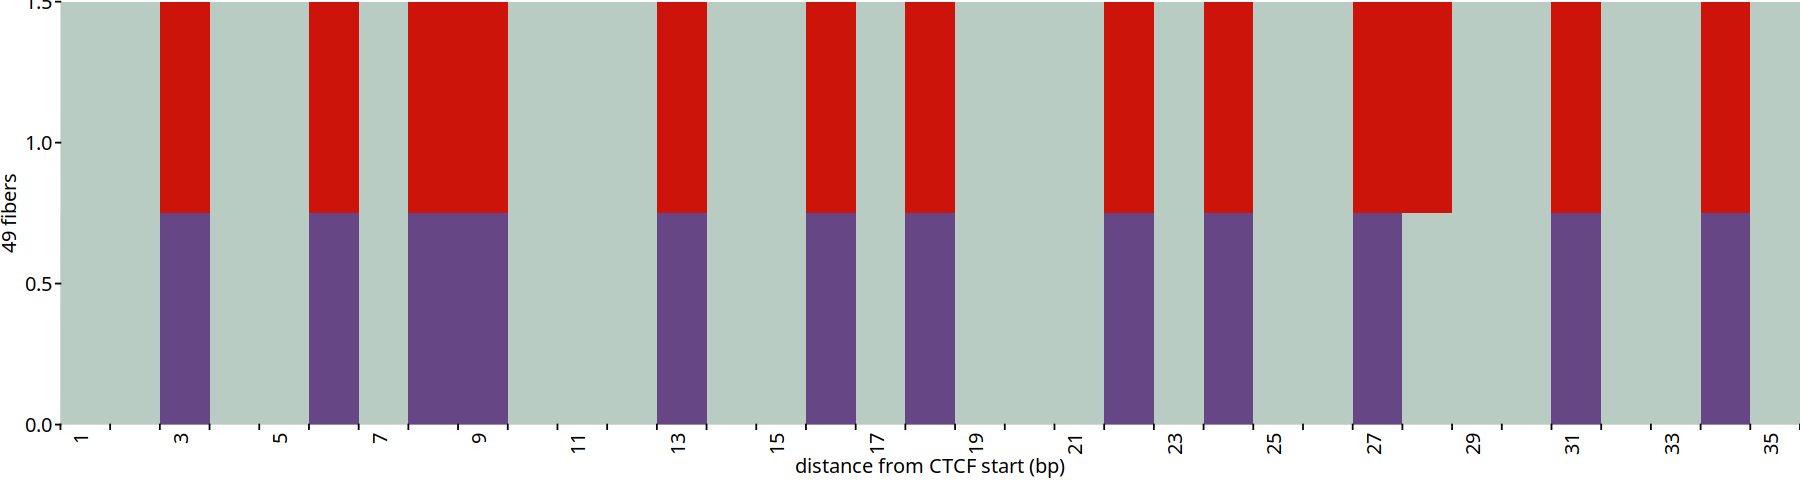

In [302]:
ggplot(test) +
    # add box over motif location
    geom_rect(aes(xmin=-100, xmax=101, ymin=(y_min+squish_fiber), ymax=(y_max-squish_fiber)), fill=mitch_cols[4], data=test) +
    # m6a positions
    geom_rect(aes(xmin=centered_start, xmax=centered_end, ymin=y_min, ymax=y_max), fill=m6a_col, data=test) +
    # ATs
    geom_rect(aes(xmin=x_min, xmax=x_max, ymin=(y_min), ymax=(y_max)), fill=bases$base_col, data=bases) +
    # fiber (gray)
    annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.2, fill=motif_annot_col) +
    scale_y_continuous(expand=expansion(add=c(0,0)), name=y_axis_name) +
    coord_cartesian(xlim=c(0,35)) +
    #ggtitle(plot_title) +
    scale_x_continuous(name=x_axis_name, expand=expansion(add=c(0, 0)), breaks=pretty_breaks(n=45),
                       labels = function(i) base_position(i)
    #                   labels = function(x) {
    #  x[seq_along(x) %% 2 == 1] <- ""
    #  x
    #}
                       ) +
    theme_classic() +
        theme(text = font_info,
        axis.ticks = element_line(color="#000000", lineend="square"),
        axis.text = font_info,
        axis.text.x = element_text(angle=90, hjust=1, vjust=2, family="ArialMT", color="black"),
        axis.line = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(family="ArialMT", size=12, hjust=0.5),
        legend.position = "none",
        plot.margin=margin(1,0,1,1,"pt"))

In [184]:
# make df w/ bases separated
bases <- test %>%
    mutate(base = strsplit(as.character(subset_sequence), "")) %>%
    unnest(base)
dim(bases)

[1] 9447   16

In [451]:
#------------ Set output file ------------
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_per_fiber_uncolored_rle-bar.pdf", file_root)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- FALSE
pdf_dims <- c(15,15)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.m6a_per_fiber_uncolored_rle-bar.pdf"


In [ ]:
# create df with a separate row per base in subset sequence
bases <- data.frame(
            motif_query = rep(unique(df_p$motif_query), 201),
            query_name = rep(unique(df_p$query_name), 201),
            y_min = rep(unique(df_p$y_min)+0.75, 201),
            y_max = rep(unique(df_p$y_max)+0.75, 201),
            x_min = -100:100,
            x_max = -99:101,
            base = strsplit(unique(test$subset_sequence), "")
        )
# rename column
names(bases)[ncol(bases)] <- "base"

# add column with color per base
DNA_bases <- c("A", "C", "G", "T")
# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# orange, grey, grey, orange (only coloring ATs)
base_cols <- c(mitch_cols[2], mitch_cols[4], mitch_cols[4], mitch_cols[2])
bases$base_col <- base_cols[match(bases$base, DNA_bases)]

In [465]:
head(df_p, 1)

motif_query,motif_name,chrom,centering_position,strand,subset_sequence,reference_start,reference_end,query_name,centered_query_start,⋯,msp_size,Label,FDR,FDR_05,FDR_01,FDR_001,FDR_0001,rle_max,y_min,y_max
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<int>,⋯,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
chr20_63786415_+/m54329U_210323_190418/137888748/ccs,chr20_63786415_+,chr20,63786415,+,AACTGCTAATGTCTGGAGACATTTTTGGTTGTACCAACGGGGGATCCAAAGGCAGGTGCTCCTGGCGTCTGTGGGTGGAGGCCACAGCTGCTGCTAACATCCTGCAGTACCCAGGACAGCCTCACGATGGAGCACAACTCAGCCCGAGGCTGAGTTAAACCAACTGCTGTTTTTTGTTTGTTTTGAGGTTTTTTGATTTGT,63781746,63793282,m54329U_210323_190418/137888748/ccs,-4692,⋯,134,Positive,0.03957827,low_FDR,high_FDR,high_FDR,high_FDR,1,0,0.75


In [467]:
# get all AT bases
df_bases <- df_p %>%
                group_by(query_name) %>%
                mutate(base = strsplit(as.character(subset_sequence), "")) %>%
                unnest(base)
df_bases <- filter(df_bases, base %in% c("A", "T"))
# add red color
df_bases$base_col <- mitch_cols[2]

In [470]:
df_bases <- ddply(df_bases, .(query_name), mutate, id=seq_along(base))
dim(df_bases)

[1] 183352     28

In [473]:
summary(df_bases[df_bases$query_name == df_bases$query_name[1],]$id)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1    1176    2350    2350    3525    4700 

In [457]:
set_plot_dimensions(15, 5)

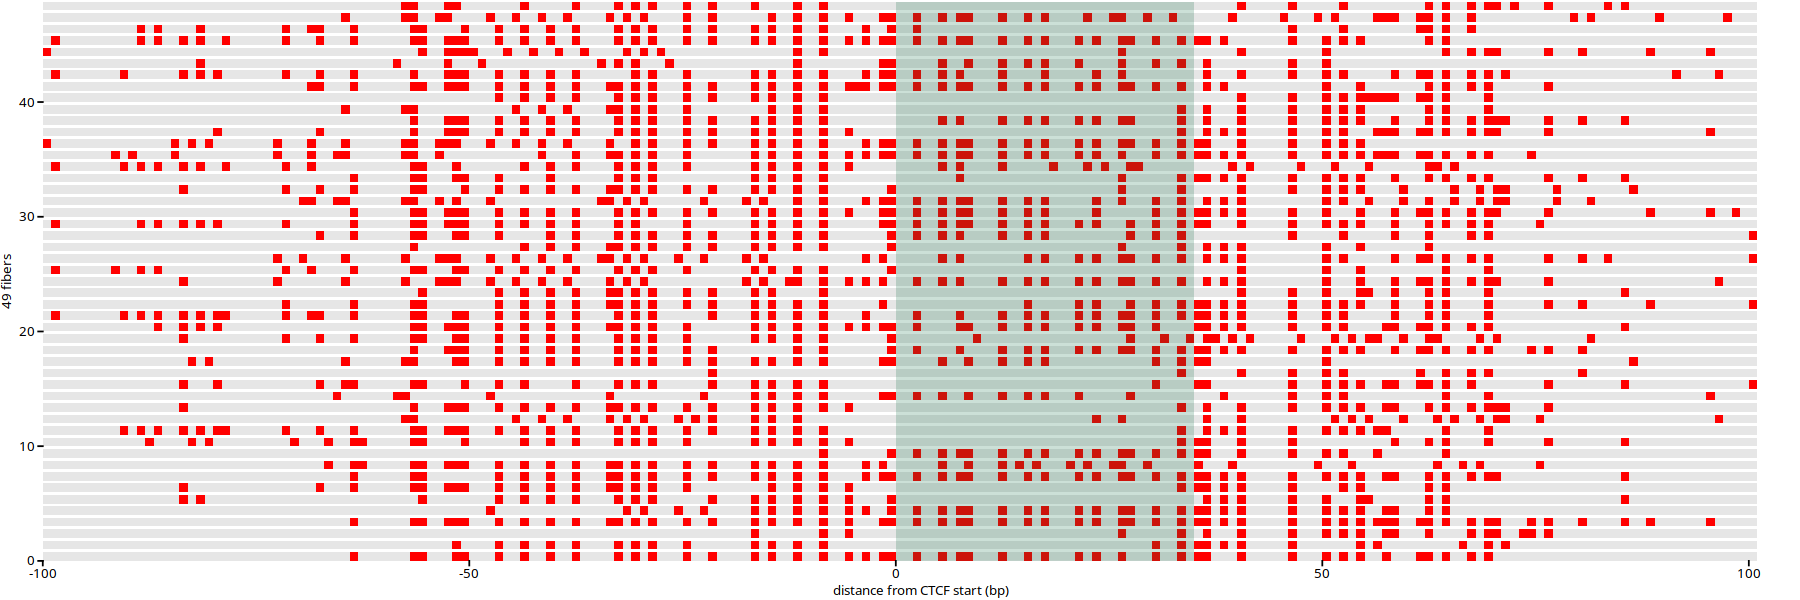

In [464]:
if (save_pdf == TRUE) {set_plot_dimensions(pdf_dims[1], pdf_dims[2])}

# create density plot
font_size <- 8
font_info <- element_text(size=font_size, family="ArialMT", color="black")

# make background fiber smaller than m6a mark
squish_fiber <- 0#0.15

p <- ggplot(df_p) +
    # add box over motif location
    geom_rect(aes(xmin=-100, xmax=101, ymin=(y_min+squish_fiber), ymax=(y_max-squish_fiber)), fill=mitch_cols[4], data=df_p) +
    # color AT positions
    geom_rect(aes(xmin=centered_start, xmax=centered_end, ymin=y_min, ymax=y_max), fill=mitch_cols[2], data=df_bases) +
    # m6a colors
    #geom_rect(aes(xmin=centered_start, xmax=centered_end, ymin=y_min, ymax=y_max), fill=m6a_col, data=df_p) +
    # fiber colors
    annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.2, fill=motif_annot_col) +
    scale_y_continuous(expand=expansion(add=c(0,0)), name=y_axis_name) +
    #coord_cartesian(xlim=c(-5,40)) +
    #ggtitle(plot_title) +
    scale_x_continuous(name=x_axis_name, expand=expansion(add=c(0, 5))) +
    theme_classic() +
        theme(text = font_info,
        axis.ticks = element_line(color="#000000", lineend="square"),
        axis.text = font_info,
        axis.line = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(family="ArialMT", size=12, hjust=0.5),
        legend.position = "none",
        plot.margin=margin(1,0,1,1,"pt"))

p
#if (save_pdf == TRUE) {ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])}

In [379]:
labels <- df_p %>% 
            group_by(query_name) %>%
            summarize(max_rle = unique(rle_max)) %>%
            ungroup()
labels <- labels$max_rle
length(labels)
length(1:49)


[1] 49

[1] 49

Warning message in geom_text(aes(label = rle_max, x = -2, y = (y_min - 0.2)), vjust = 0, :
"Ignoring unknown parameters: `face`"


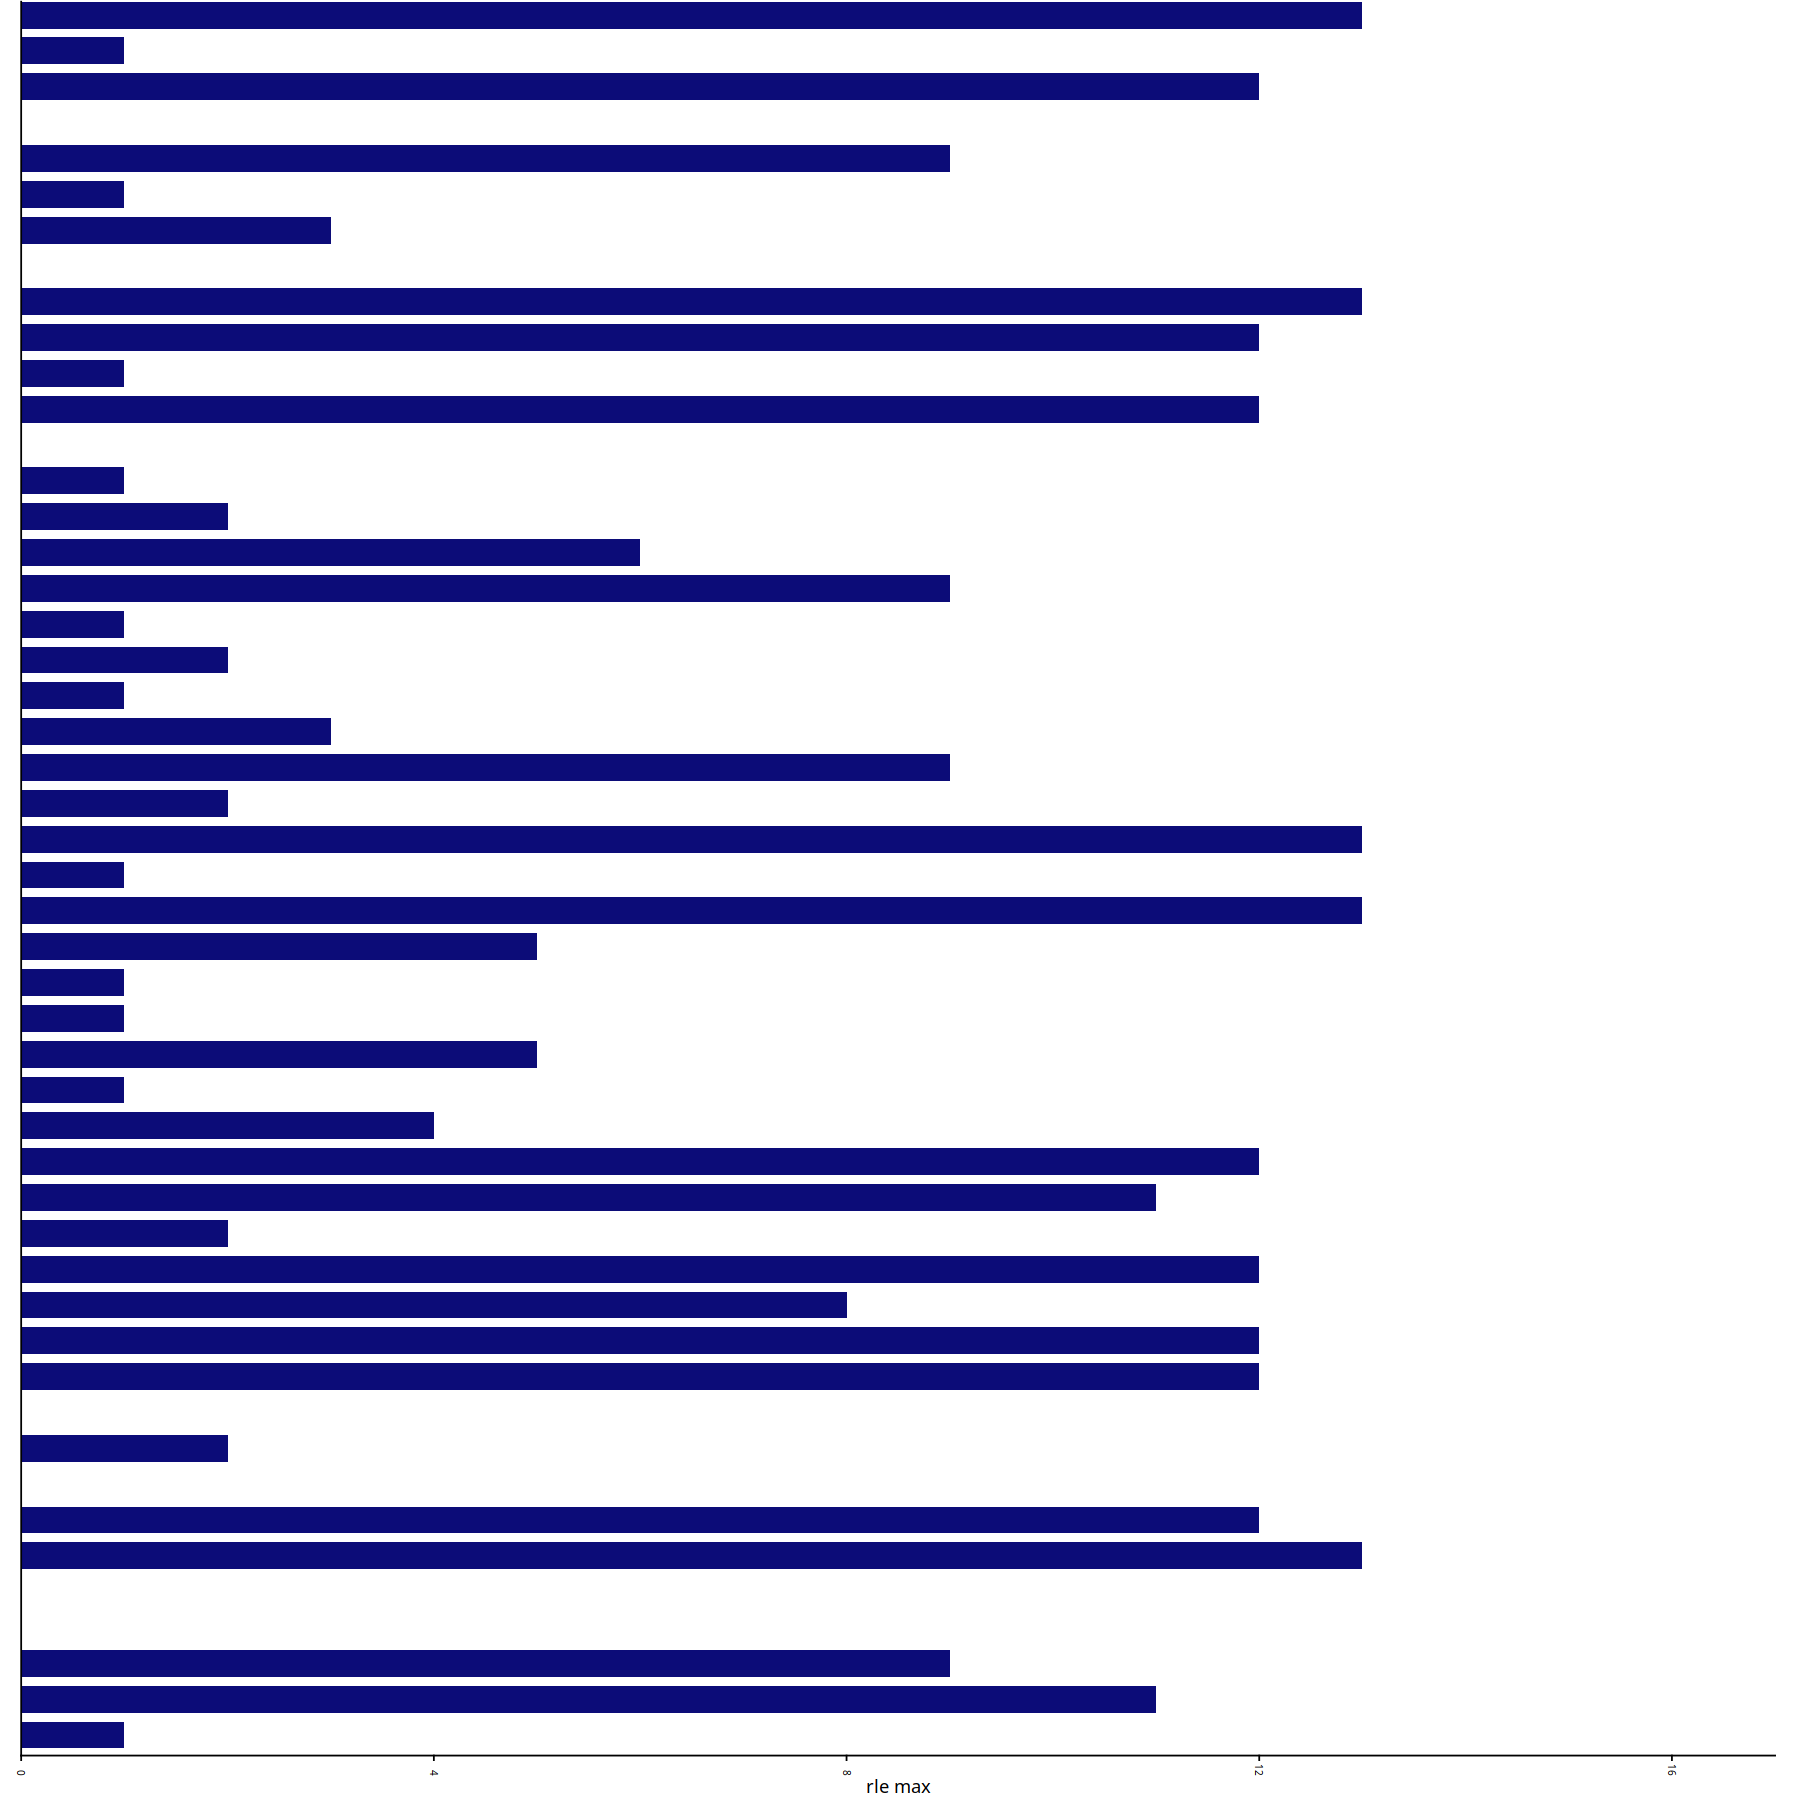

In [438]:
# make rle max bar larger than m6a mark
rle_stretch <- 0

p2 <- ggplot(df_p) +
        geom_rect(aes(xmin=0, xmax=rle_max, ymin=(y_min)-rle_stretch, ymax=(y_max+rle_stretch)),
                  fill=mitch_cols[5]) +
        geom_text(aes(label=rle_max, x=-2, y=(y_min-0.2)), vjust=0, hjust=1, 
                  size=2, family="ArialMT", color="black", face="plain") +
        scale_y_continuous(expand=expansion(add=c(0,NA))) +#, breaks=1:49, labels=labels) +#, limits=c(-0.5,49)) +
        scale_x_continuous(limits=c(-3, 17), expand=c(0,0), position="bottom", name="rle max") +
        coord_cartesian(xlim=c(0, 17), clip="off") +
        theme_classic() +
        theme(#text = font_info,
                axis.ticks = element_line(color="#000000", lineend="square"),
                axis.text.x = element_text(angle=-90, hjust=1, vjust=0.5,
                                           size=6, family="ArialMT", color="black"),
                axis.text.y=element_blank(),
                axis.ticks.y=element_blank(),
                axis.title.y=element_blank(),
                axis.line = element_line(color="#000000", lineend="square"),
                #panel.background = element_rect(fill="transparent", color="#000000", size=1),
                legend.position = "none",
                plot.margin = margin(t=1, r=15, b=1, l=10))

p2

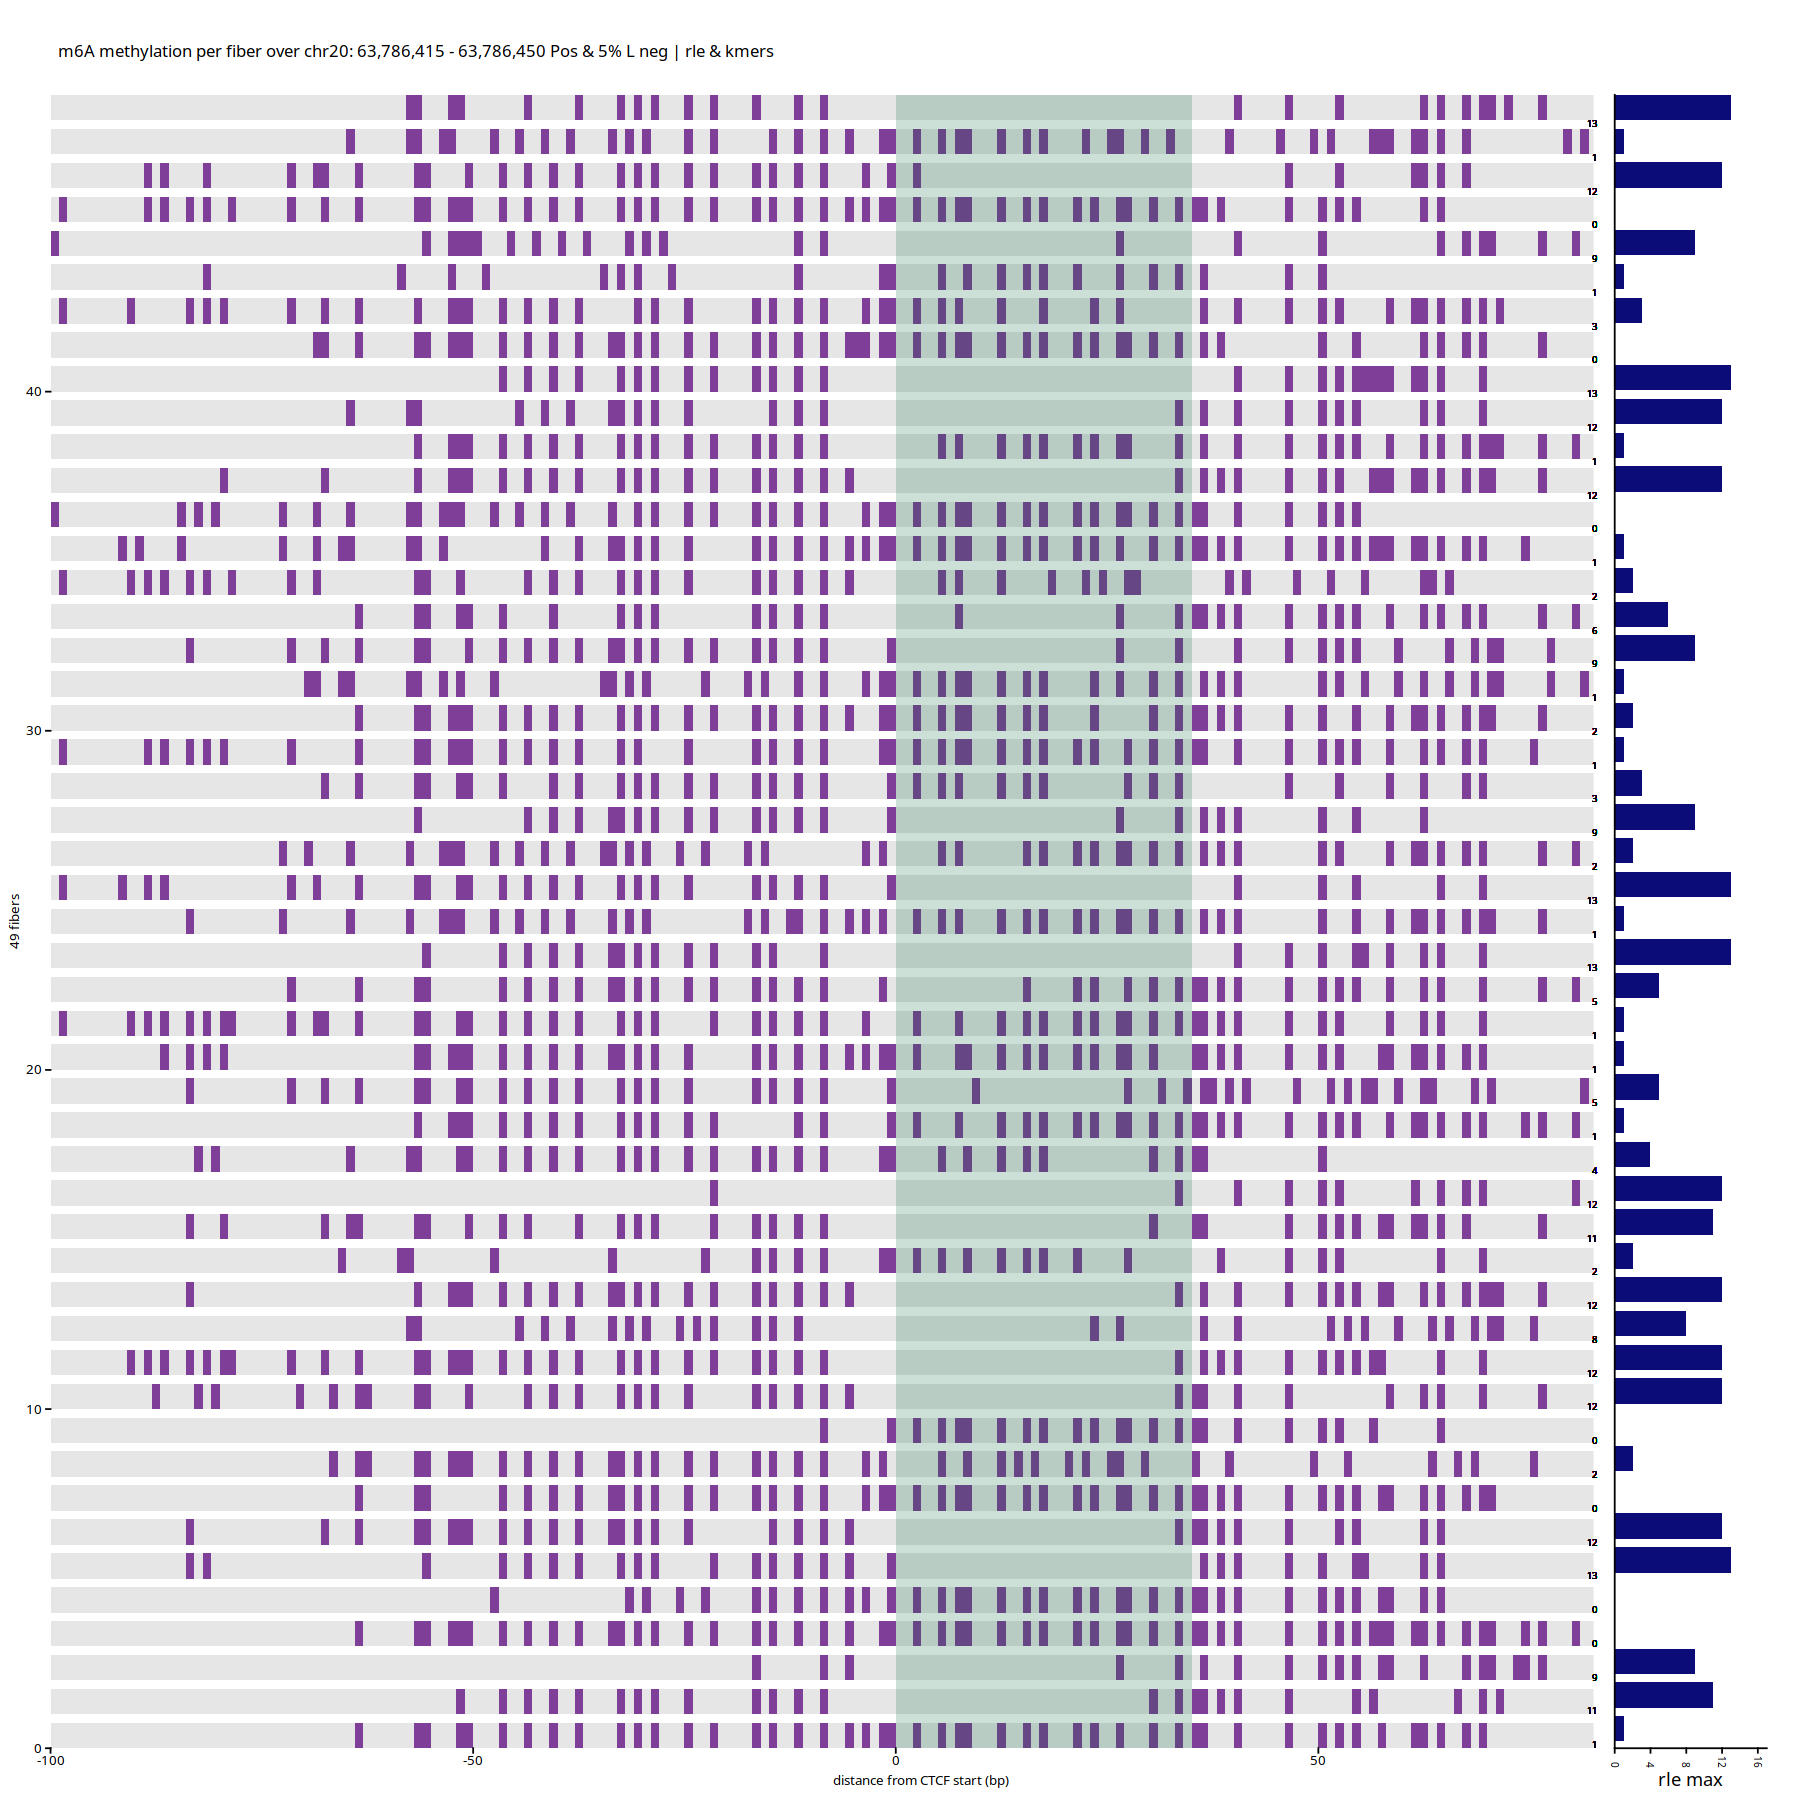

In [439]:
# merge plots and save
plot_title <- sprintf("m6A methylation per fiber over %s: %s - %s %s | rle & kmers", 
    motif_coords[1],
    format(as.numeric(motif_coords[2]), big.mark=",", scientific=FALSE),
    format(as.numeric(motif_coords[3]), big.mark=",", scientific=FALSE),
    "Pos & 5% L neg")

title <- ggdraw() + draw_label(plot_title, size=10, x=0, hjust=0) +
    theme(plot.margin = margin(t=0, r=0, b=0, l=30))

p3 <- plot_grid(p, NULL, p2, rel_widths=c(0.9, -0.1, 0.1), nrow=1, align = "h")
p4 <- plot_grid(title, p3, ncol=1, rel_heights=c(0.05, 1))
p4 <- p4 + theme(plot.margin=margin(5,5,5,5))
p4
save_plot(output_file, p4, base_width=pdf_dims[1], base_height=pdf_dims[2])

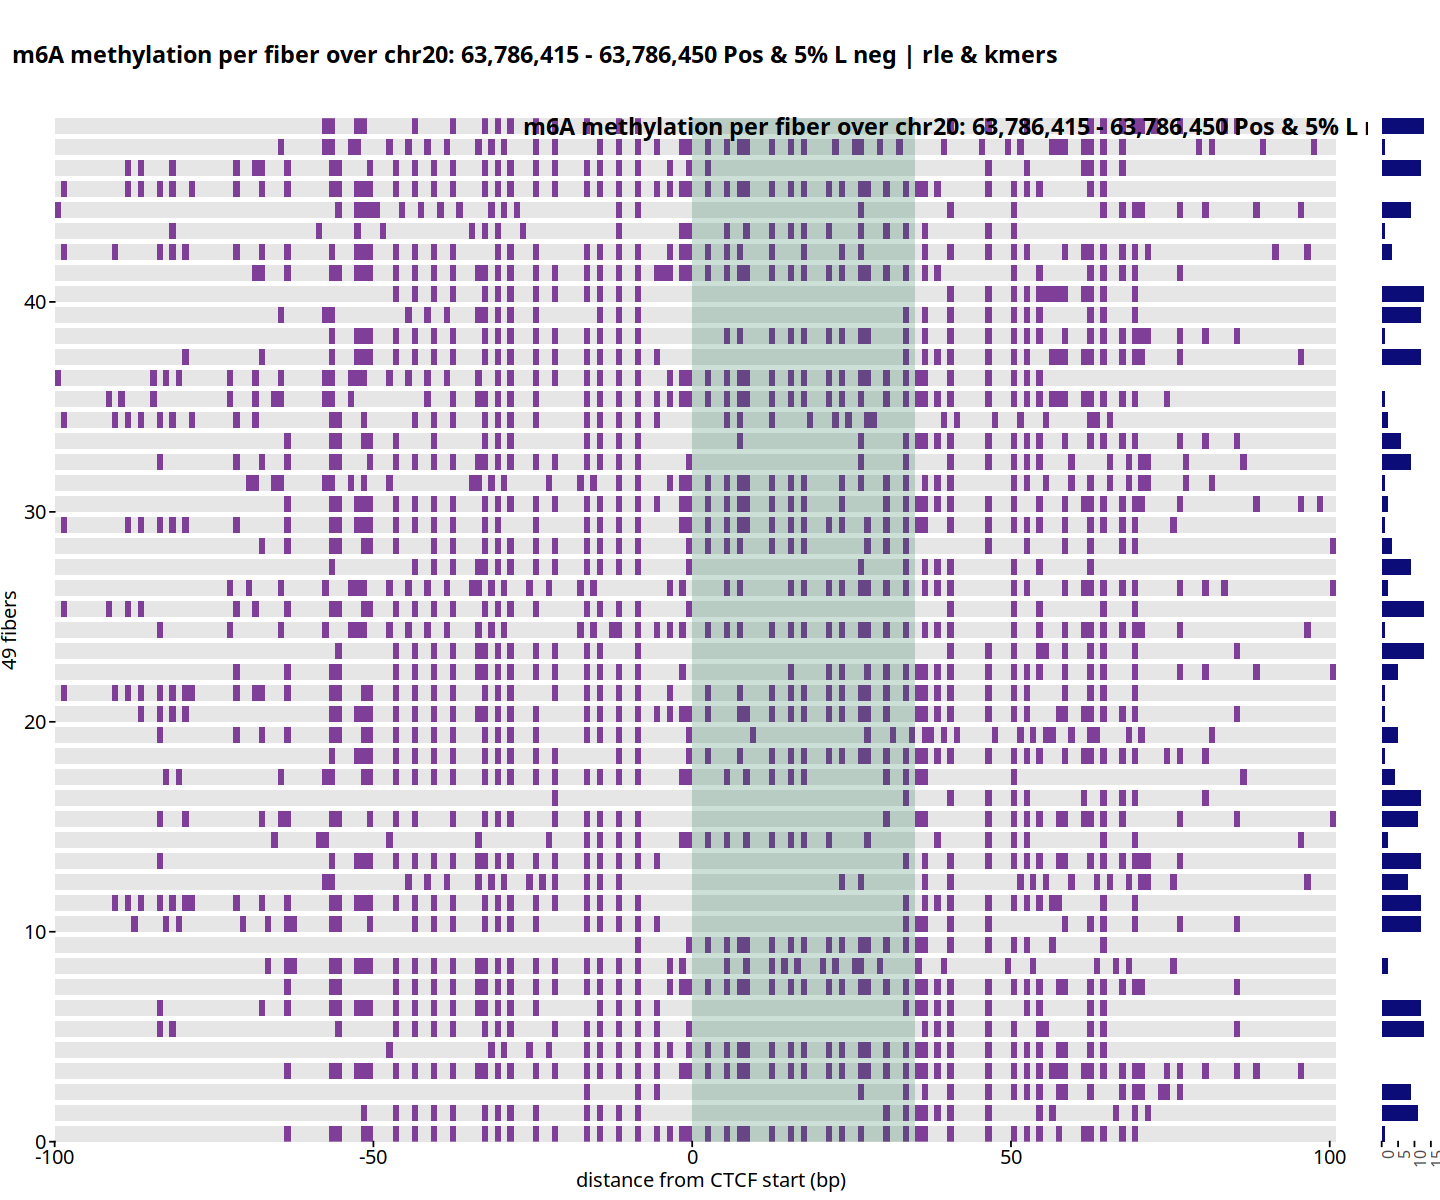

In [35]:
# merge plots and save
plot_title <- sprintf("m6A methylation per fiber over %s: %s - %s %s | rle & kmers", 
    motif_coords[1],
    format(as.numeric(motif_coords[2]), big.mark=",", scientific=FALSE),
    format(as.numeric(motif_coords[3]), big.mark=",", scientific=FALSE),
    "Pos & 5% L neg")


#p3 <- plot_grid(p, p2, labels=plot_title, label_y=1, rel_widths=c(0.95, 0.05), nrow=1, align = "h")

#p3_title <- ggdraw() + draw_label(plot_title, fontface="bold")
plot_grid(title, p3, ncol=1, rel_heights=c(0.1, 1))
#save_plot(output_file, p3)

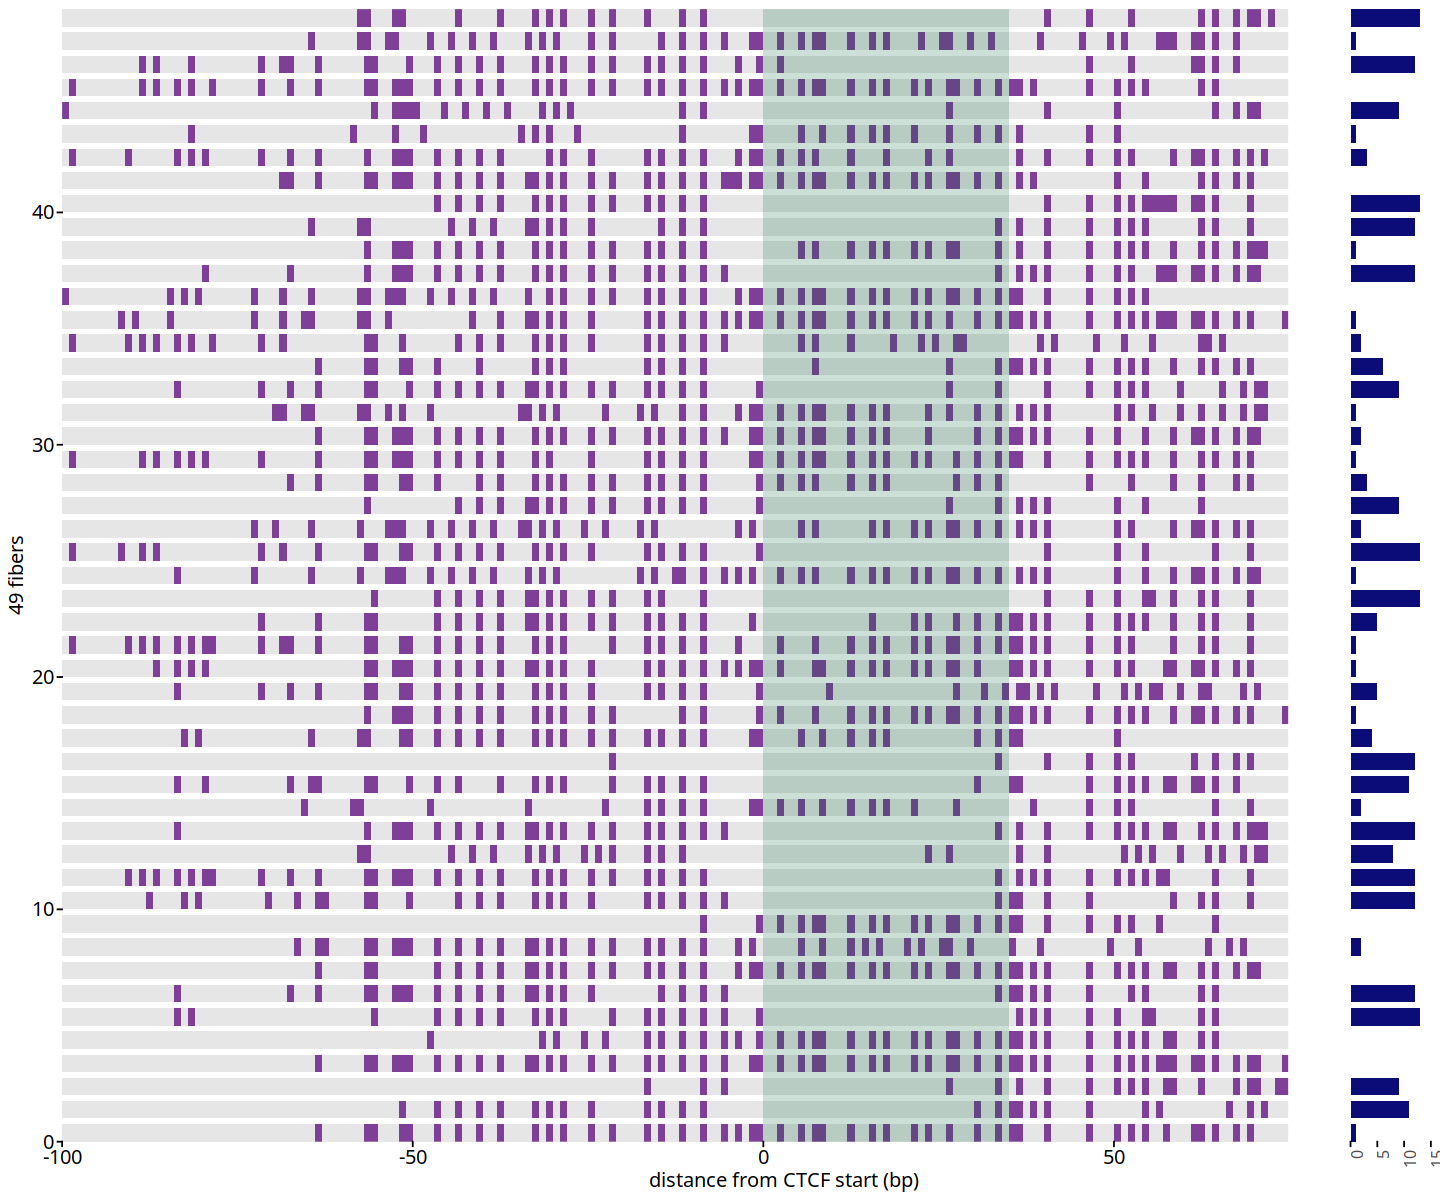

In [33]:
plot_grid(p, NULL, p2, rel_widths=c(1,-0.15,0.1), nrow=1, align = "vh")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


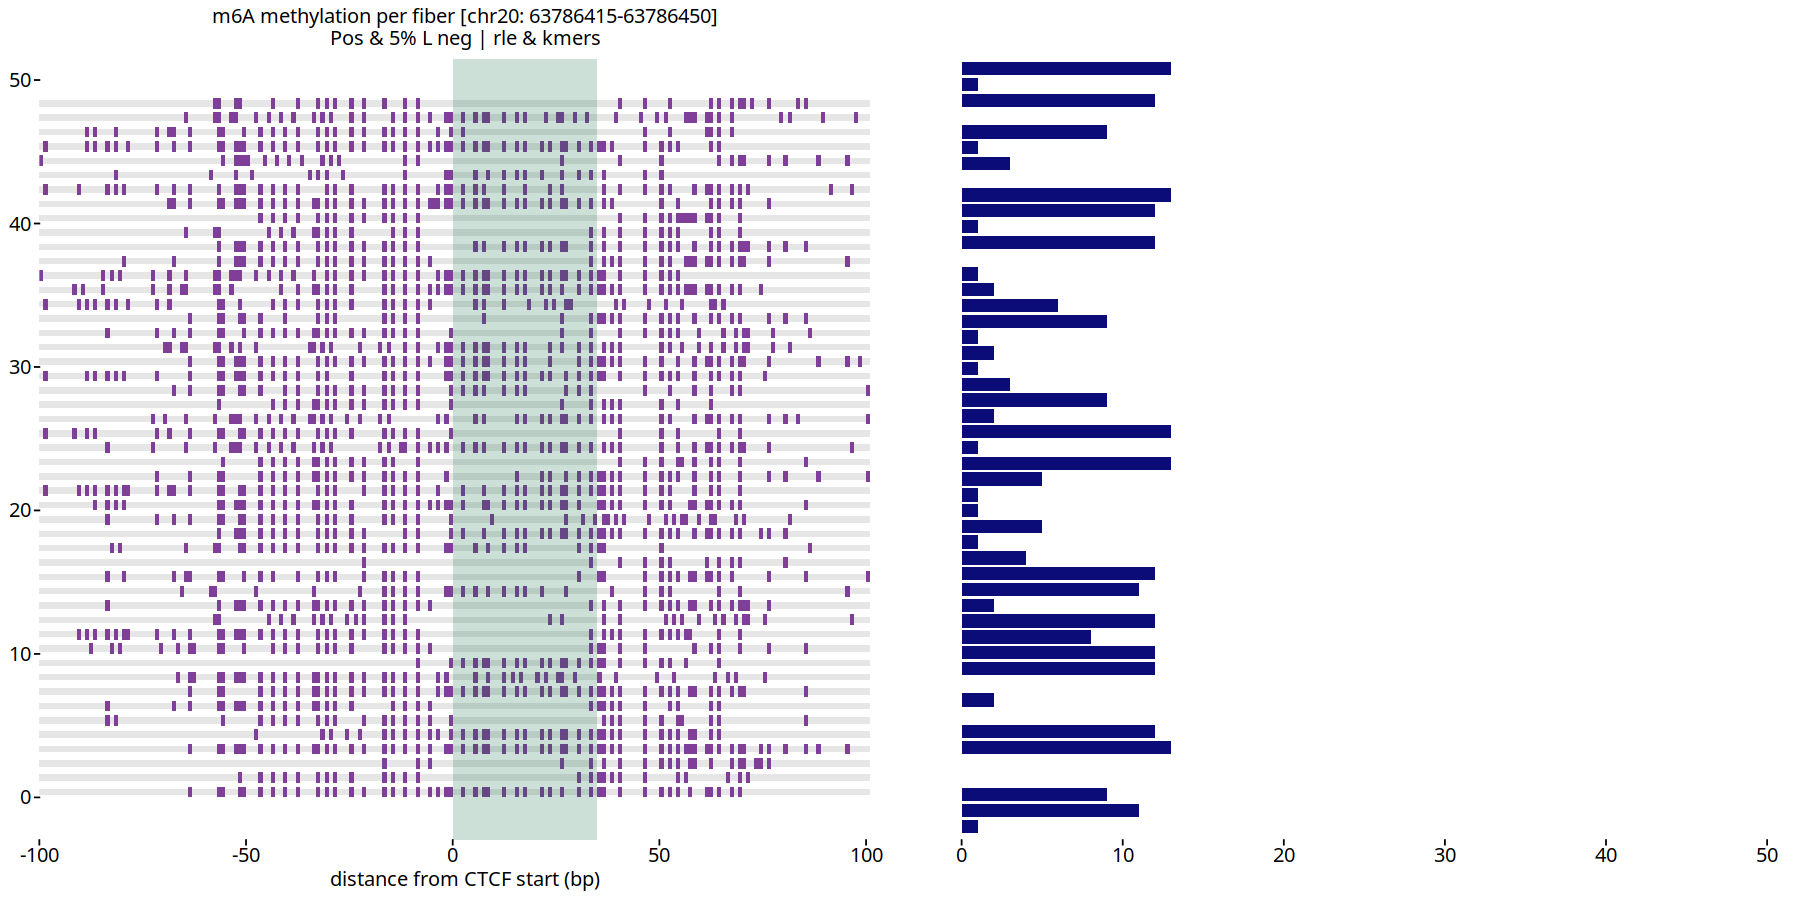

In [119]:
# assign common axis to both plots
y_lims <- c(-0.5, 49)
p.common.y <- p + scale_y_continuous(limits=y_lims)
p2.common.y <- p2 + scale_x_continuous(limits=y_lims)

# build the plots
p.common.y <- ggplot_gtable(ggplot_build(p.common.y))
p2.common.y <- ggplot_gtable(ggplot_build(p2.common.y))

# copy plot height from p1 to p2
p2.common.y$heights <- p.common.y$heights

#plot_grid(p, NULL, p2, rel_widths=c(1,-0.15,0.1), nrow=1, align = "vh")
grid.arrange(p.common.y, p2.common.y, ncol=2, nrow = 1)

In [234]:
moka <- filter(res, motif_query %in% df$motif_query)
dim(moka)

[1] 1829   22

In [247]:
# plot m6a instances in coords
motif_coords <- c("chr20", 63786415, 63786450)

In [248]:
# create density plot
font_size <- 12
font_info <- element_text(size=font_size, family="ArialMT", color="black")

#### purple (FDR sorted)

In [ ]:
# make plotting data
df_p <- moka[, c("motif_query", "motif_name", "query_name", "centered_start", "centered_end", "FDR")]

In [ ]:
# sort rows by similarity

# create vector of 0s for m6a positions
df_m6a <- data.frame(matrix(0, ncol = 49, nrow = 201))
colnames(df_m6a) <- unique(df_p$query_name)
rownames(df_m6a) <- 1:nrow(df_m6a)

for (name in unique(df_p$query_name)) {
    # add 101 to positions to make them positive & match index
    m6a_positions <- df_p[df_p$query_name == name]$centered_start + 101
    x <- numeric(201)
    x[m6a_positions] <- 1
    df_m6a[name] <- x
}

unsorted_df <- t(df_m6a)
N <- nrow(unsorted_df)
same1 <- function(x, y) sum((x+y) == 2, na.rm=TRUE)
df_list <- unlist(apply(unsorted_df, 1, list),F,F)
df_combos <- which(upper.tri(matrix(NA, nrow=N, ncol=N)),arr.ind=T) #expand.grid(1:length(df_list),1:length(df_list))
commonality <- mapply(same1, df_list[df_combos[,1]], df_list[df_combos[,2]])
best_match <- c()
for(i in 1:length(df_list)){
    best_match[i] <- max(commonality[apply(df_combos,1,function(x)i%in%x)])
}

sorted_df <- unsorted_df[order(best_match, decreasing=TRUE),]
sorted_fibers <- rownames(sorted_df)

# sort by similarity
#df_p <- df_p %>% arrange(factor(query_name, levels=sorted_fibers))
df_p$query_name <- factor(df_p$query_name, levels=sorted_fibers)
df_p <- df_p[order(df_p$query_name)]

In [ ]:
#------------ Set output file ------------
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_per_fiber_uncolored.pdf", file_root)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- TRUE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.m6a_per_fiber_uncolored.pdf"


In [ ]:
# add col with y-axis coords
y_min <- seq(from=0, by=1, length.out=length(unique(df_p$query_name)))
y_max <- seq(from=0.75, by=1, length.out=length(unique(df_p$query_name)))

y_min_vals <- setNames(y_min, unique(df_p$query_name))
y_max_vals <- setNames(y_max, unique(moka$query_name))

df_p <- df_p %>%
            mutate(
                y_min = y_min_vals[query_name],
                y_max = y_max_vals[query_name]
            )
dim(df_p)

[1] 1829    8

In [ ]:
# set y-lim
y_limits <- c(0, NA)#round_any(max(density(df$centered_start)$y)*1.2, 0.001, f=ceiling))
x_limits <- c(-100, 100)

plot_title <- sprintf("m6A methylation per fiber [%s: %s-%s]\n%s | rle & kmers", 
                      motif_coords[1],
                      format(motif_coords[2], big.mark=",", scientific=FALSE),
                      format(motif_coords[3], big.mark=",", scientific=FALSE),  
                      "Pos & 5% L neg")
x_axis_name <- "distance from CTCF start (bp)"
y_axis_name <- sprintf("%s fibers", length(unique(df_p$query_name)))
#legend_labels <- c(sprintf("FDR > %s", FDR), sprintf("FDR < %s", FDR))

In [ ]:
# define colors (light grey, purple, darker grey, blue)
vline_col <- "#CECDCC"
m6a_col <- "#7F3F98"
fiber_col <- "#D1D2D4"
motif_annot_col <- "#006738"#"#6C9272"#"blue"
# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# neg, high m6A & no TF: blue | pos, no m6A & TF: red
color_vals <- c(mitch_cols[5], mitch_cols[2])

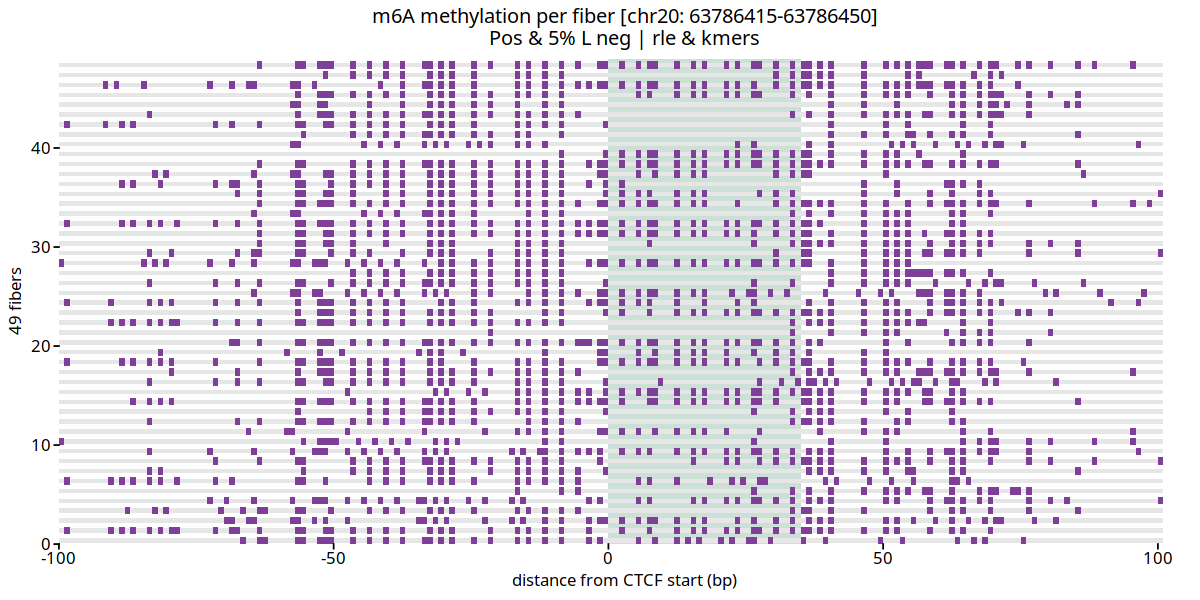

In [ ]:
if (save_pdf == TRUE) {set_plot_dimensions(pdf_dims[1], pdf_dims[2])}

# make background fiber smaller than m6a mark
squish_fiber <- 0.15

p <- ggplot(df_p) +
    # add box over motif location
        annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.2, fill=motif_annot_col) +
        geom_rect(aes(xmin=-100, xmax=101, ymin=(y_min+squish_fiber), ymax=(y_max-squish_fiber)), fill=mitch_cols[4], data=df_p) +
        geom_rect(aes(xmin=centered_start, xmax=centered_end, ymin=y_min, ymax=y_max), fill=m6a_col, data=df_p) +
        scale_y_continuous(limits=c(0, 49), expand=expansion(add=c(0,0)), name=y_axis_name) +
        ggtitle(plot_title) +
        scale_x_continuous(name=x_axis_name, expand=expansion(add=c(0, 5))) +
        theme_classic() +
            theme(text = font_info,
            axis.ticks = element_line(color="#000000", lineend="square"),
            axis.text = font_info,
            axis.line = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(family="ArialMT", size=12, hjust=0.5),
            legend.position = "none")

p

if (save_pdf == TRUE) {
    ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])
}

##### purple & sorted

In [ ]:
#------------ Set output file ------------
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_per_fiber_uncolored_FDR_sorted.pdf", file_root)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file?
save_pdf <- TRUE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.m6a_per_fiber_uncolored_FDR_sorted.pdf"


In [ ]:
# set plot parameters
plot_title <- sprintf("(%s) m6a instances per fiber (%s) over %s: %s-%s",
                      "Pos & 5% L neg", length(unique(df_p$query_name)), motif_coords[1], motif_coords[2], motif_coords[3])
x_axis_name <- "area surrounding motif (bp)"
y_axis_name <- sprintf("%s fibers", length(unique(df_p$query_name)))
font_size <- 10
font_info <- element_text(size=font_size, family="ArialMT", color="black")

# grey
vline_col <- "#CECDCC"
# purple
m6a_col <- "#7F3F98"
# gray
fiber_col <- "#D1D2D4"

# colors from Mitchell's presentation
# orange, red, purple, light grey, navy (gene track)
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")

In [ ]:
# add color based on FDR value
# purple, red
fill_cols <- c(m6a_col, m6a_col)

df_p$fill_col <- ifelse(df_p$FDR <= FDR, fill_cols[1], fill_cols[2])
df_p$FDR_group <- ifelse(df_p$FDR <= FDR, "low_FDR", "high_FDR")

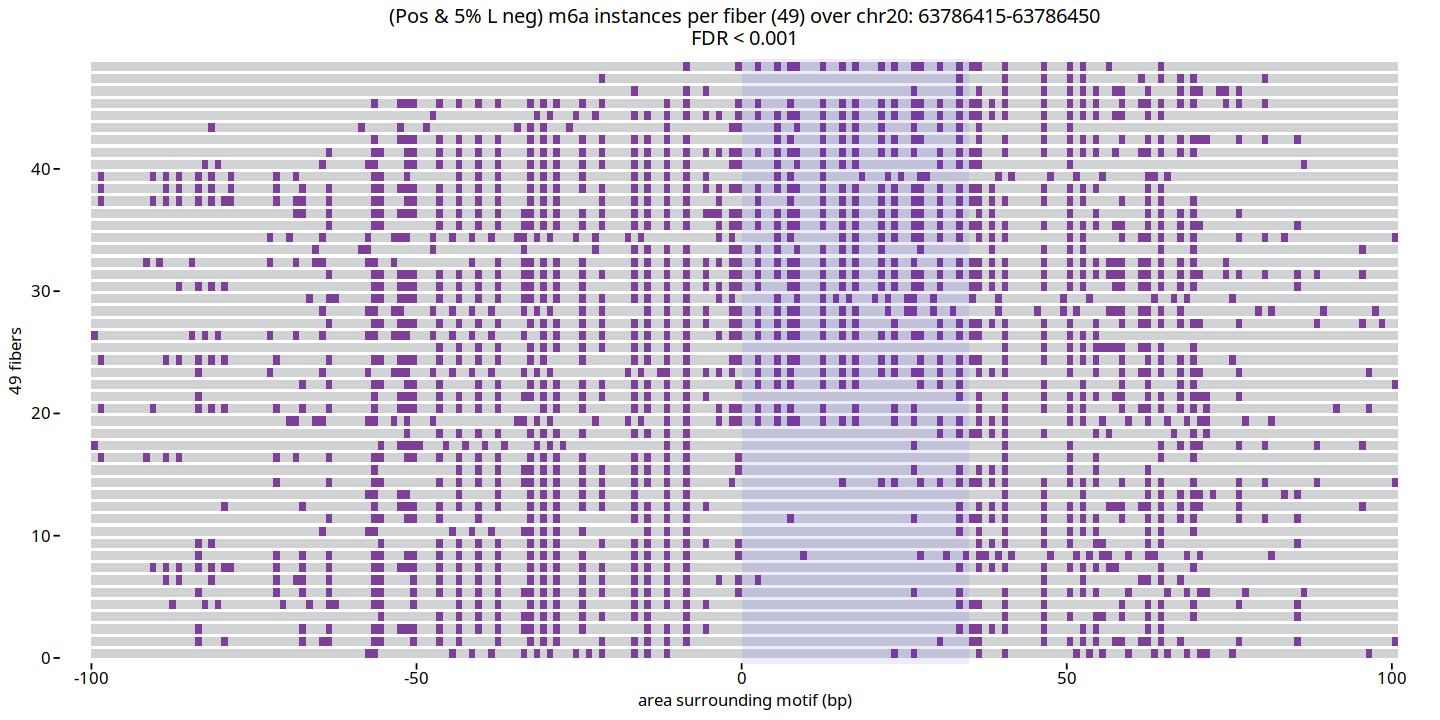

In [ ]:
# plot (colored by FDR)

p <- ggplot(df_p) +
        geom_rect(aes(xmin=x_min, xmax=x_max, ymin=y_min, ymax=y_max), fill=fiber_col, data=df_fiber) +
        geom_rect(aes(xmin=centered_start, xmax=centered_end, ymin=y_min, ymax=y_max, group=FDR_group), fill=df_p$fill_col, data=df_p) +
        scale_color_identity() +
        # add box over motif location
        annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.075, fill="blue") +
        scale_y_continuous(limits=c(0, 49), expand=expansion(add=c(0.5,0)), name=y_axis_name) +
        ggtitle(plot_title) +
        scale_x_continuous(name=x_axis_name, expand=expansion(add=c(5, 5))) +
        theme_classic() +
            theme(text = font_info,
            axis.ticks = element_line(color="#000000", lineend="square"),
            axis.text = font_info,
            axis.line = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(family="ArialMT", size=12, hjust=0.5),
            legend.position = "none")
p

if (save_pdf == TRUE) {
    ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])
}

### colored by FDR

#### FDR gradient

In [238]:
# make plotting data
df_p <- moka[, c("motif_query", "motif_name", "query_name", "centered_start", "centered_end", "FDR")]
     

In [239]:
#------------ Set output file ------------
FDR <- 0.05
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_per_fiber_log2_FDR.pdf", file_root)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- FALSE
pdf_dims <- c(15,6)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.m6a_per_fiber_log2_FDR.pdf"


In [240]:
# sort by FDR value
df_p <- df_p[order(df_p$FDR, decreasing=TRUE)]

# add col with y-axis coords
y_min <- seq(from=0, by=1, length.out=length(unique(df_p$query_name)))
y_max <- seq(from=0.75, by=1, length.out=length(unique(df_p$query_name)))

y_min_vals <- setNames(y_min, unique(df_p$query_name))
y_max_vals <- setNames(y_max, unique(df_p$query_name))

df_p <- df_p %>%
            mutate(
                y_min = y_min_vals[query_name],
                y_max = y_max_vals[query_name]
            )

# get plot limits
x_min <- max(df_p$centered_start)
x_max <- min(df_p$centered_end)
# number of fibers
n_fibers <- length(unique(df_p$query_name))

In [241]:
# define colors (light grey, purple, darker grey, blue)
vline_col <- "#CECDCC"
m6a_col <- "#7F3F98"
fiber_col <- "#D1D2D4"
motif_annot_col <- "#006738"#"#6C9272"#"blue"

# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# neg, high m6A & no TF: blue | pos, no m6A & TF: red
color_vals <- c(mitch_cols[2], mitch_cols[5])

# add color based on FDR value
df_p$fill_col <- ifelse(df_p$FDR <= FDR, color_vals[1], color_vals[2])
df_p$FDR_group <- ifelse(df_p$FDR <= FDR, "low_FDR", "high_FDR")

In [249]:
# make plot & axes titles
y_limits <- c(0, NA)
x_limits <- c(-100, 100)
plot_title <- sprintf("m6A methylation per fiber over %s: %s - %s (log2 FDR)\n%s | rle & kmers", 
                      motif_coords[1],
                      format(as.numeric(motif_coords[2]), big.mark=",", scientific=FALSE),
                      format(as.numeric(motif_coords[3]), big.mark=",", scientific=FALSE),
                      "Pos & 5% L neg")
x_axis_name <- "distance from CTCF start (bp)"
y_axis_name <- sprintf("%s fibers", length(unique(df_p$query_name)))
#legend_labels <- c(sprintf("FDR > %s", FDR), sprintf("FDR < %s", FDR))

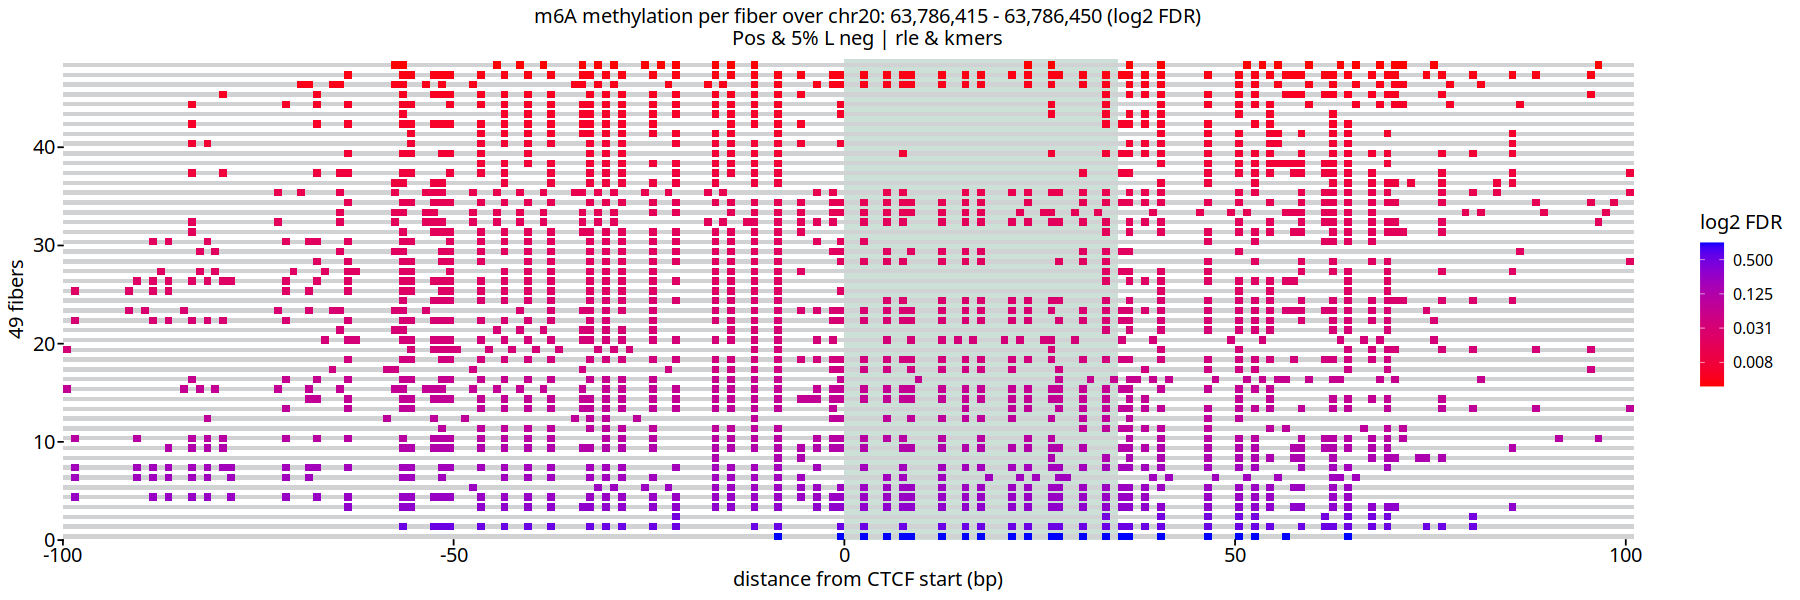

In [250]:
if (save_pdf == TRUE) {set_plot_dimensions(pdf_dims[1], pdf_dims[2])} else {set_plot_dimensions(15, 5)}

# make background fiber smaller than m6a mark
squish_fiber <- 0.15

# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# neg, high m6A & no TF: blue | pos, no m6A & TF: red
color_vals <- c(mitch_cols[2], mitch_cols[5])

# plot (colored by FDR)
p <- ggplot(df_p) +
        # add box over motif location
        annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.2, fill=motif_annot_col) +
        geom_rect(aes(xmin=-100, xmax=101, ymin=(y_min+squish_fiber), ymax=(y_max-squish_fiber)), fill=fiber_col, data=df_p) +
        geom_rect(aes(xmin=centered_start, xmax=centered_end, ymin=y_min, ymax=y_max, group=FDR_group, fill=FDR), data=df_p) +
        scale_fill_gradient(low="red", high="blue", trans="log2", expand = expansion(mult=c(0.5, 0.5)), n.breaks=5,
                            guide=guide_colorbar(barwidth=1, draw.ulim=TRUE, draw.llim=TRUE, title="log2 FDR"),
                            labels=function(x) format(round(x, 3), nsmall=2, scientific=FALSE),) +
        ggtitle(plot_title) +
        scale_y_continuous(limits=c(0, 49), expand=expansion(add=c(0,0)), name=y_axis_name) +
        scale_x_continuous(name=x_axis_name, expand=expansion(add=c(0, 5))) +
        theme_classic() +
            theme(text = font_info,
            axis.ticks = element_line(color="#000000", lineend="square"),
            axis.text = font_info,
            axis.line = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(family="ArialMT", size=12, hjust=0.5))
p

if (save_pdf == TRUE) {ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])}

#### FDR < 0.05

In [ ]:
#------------ Set output file ------------
FDR <- 0.05
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_per_fiber_FDR_%s.pdf", file_root, FDR)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- TRUE
pdf_dims <- c(15,6)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.m6a_per_fiber_FDR_0.05.pdf"


In [ ]:
# make plotting data
df_p <- moka[, c("motif_query", "motif_name", "query_name", "centered_start", "centered_end", "FDR")]
     

In [ ]:
# sort by FDR value
df_p <- df_p[order(df_p$FDR, decreasing=TRUE)]

# add col with y-axis coords
y_min <- seq(from=0, by=1, length.out=length(unique(df_p$query_name)))
y_max <- seq(from=0.75, by=1, length.out=length(unique(df_p$query_name)))

y_min_vals <- setNames(y_min, unique(df_p$query_name))
y_max_vals <- setNames(y_max, unique(df_p$query_name))

df_p <- df_p %>%
            mutate(
                y_min = y_min_vals[query_name],
                y_max = y_max_vals[query_name]
            )

# get plot limits
x_min <- max(df_p$centered_start)
x_max <- min(df_p$centered_end)
# number of fibers
n_fibers <- length(unique(df_p$query_name))

In [ ]:
# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# neg, high m6A & no TF: blue | pos, no m6A & TF: red
color_vals <- c(mitch_cols[2], mitch_cols[5])

# add color based on FDR value
df_p$fill_col <- ifelse(df_p$FDR <= FDR, color_vals[1], color_vals[2])
df_p$FDR_group <- ifelse(df_p$FDR <= FDR, "low_FDR", "high_FDR")

In [ ]:
# make plot & axes titles
y_limits <- c(0, NA)
x_limits <- c(-100, 100)
plot_title <- sprintf("FDR sorted m6A methylation per fiber over %s: %s - %s (FDR < %s)\n%s | rle & kmers | FDR < %s: %s | FDR > %s: %s", 
                      motif_coords[1],
                      format(as.numeric(motif_coords[2]), big.mark=",", scientific=FALSE),
                      format(as.numeric(motif_coords[3]), big.mark=",", scientific=FALSE),
                      FDR, "Pos & 5% L neg", FDR,
                      format(table(df_p$FDR_group)["low_FDR"], big.mark=",", scientific=FALSE), FDR,
                      format(table(df_p$FDR_group)["high_FDR"], big.mark=",", scientific=FALSE))
x_axis_name <- "distance from CTCF start (bp)"
y_axis_name <- sprintf("%s fibers", length(unique(df_p$query_name)))
#legend_labels <- c(sprintf("FDR > %s", FDR), sprintf("FDR < %s", FDR))

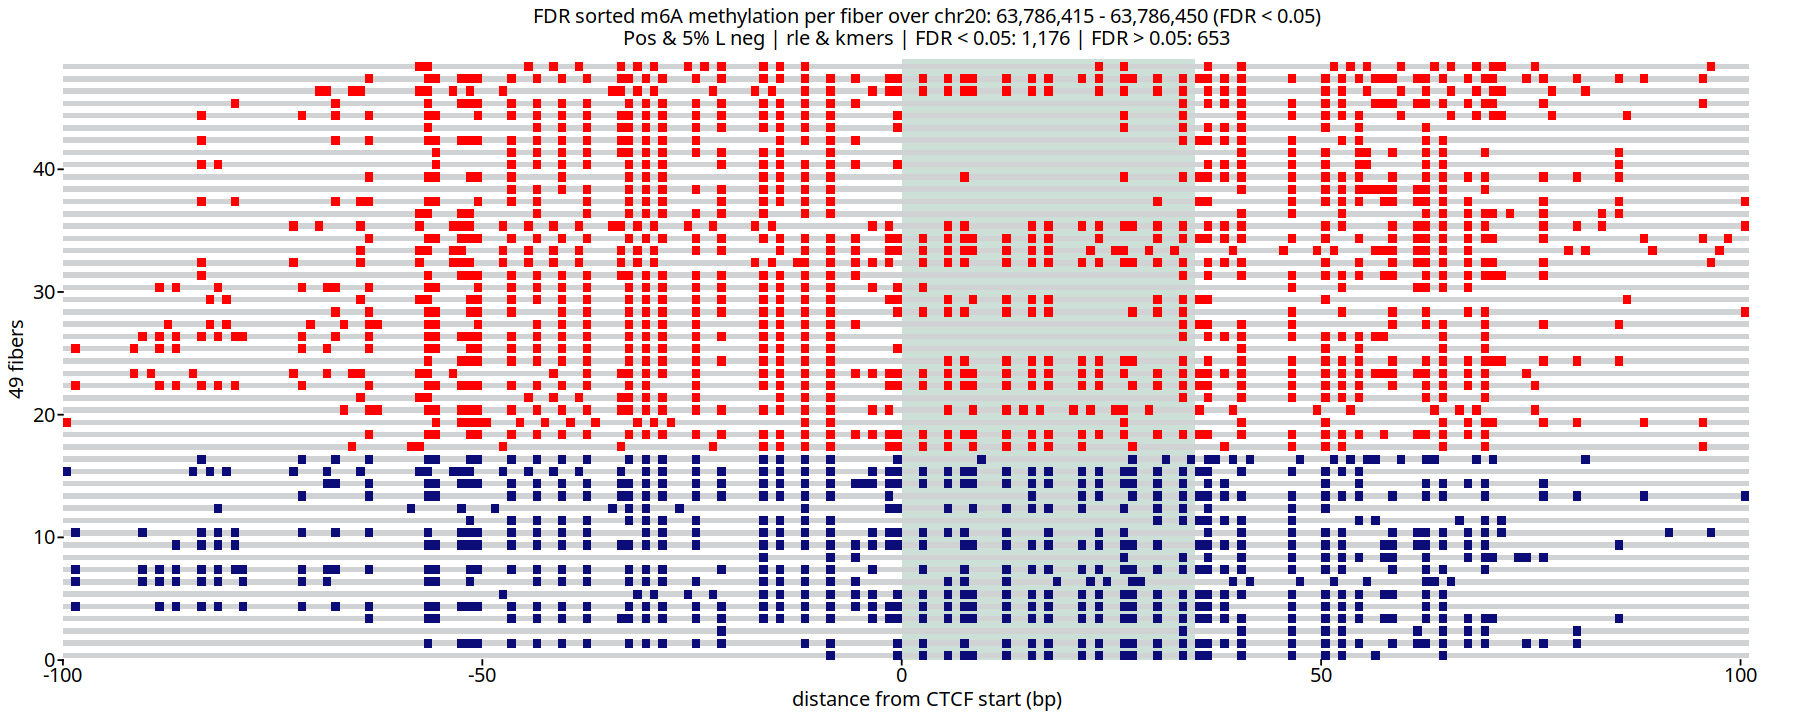

In [ ]:
if (save_pdf == TRUE) {set_plot_dimensions(pdf_dims[1], pdf_dims[2])} else {set_plot_dimensions(15, 5)}

# make background fiber smaller than m6a mark
squish_fiber <- 0.15

# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# neg, high m6A & no TF: blue | pos, no m6A & TF: red
color_vals <- c(mitch_cols[2], mitch_cols[5])

# plot (colored by FDR)
p <- ggplot(df_p) +
        # add box over motif location
        annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.2, fill=motif_annot_col) +
        geom_rect(aes(xmin=-100, xmax=101, ymin=(y_min+squish_fiber), ymax=(y_max-squish_fiber)), fill=fiber_col, data=df_p) +
        geom_rect(aes(xmin=centered_start, xmax=centered_end, ymin=y_min, ymax=y_max, group=FDR_group), fill=df_p$fill_col, data=df_p) +
        scale_color_identity() +
        ggtitle(plot_title) +
        scale_y_continuous(limits=c(0, 49), expand=expansion(add=c(0,0)), name=y_axis_name) +
        scale_x_continuous(name=x_axis_name, expand=expansion(add=c(0, 5))) +
        theme_classic() +
            theme(text = font_info,
            axis.ticks = element_line(color="#000000", lineend="square"),
            axis.text = font_info,
            axis.line = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(family="ArialMT", size=12, hjust=0.5))#,
            #legend.position = "none")
p

if (save_pdf == TRUE) {ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])}

#### FDR < 0.01

In [ ]:
#------------ Set output file ------------
FDR <- 0.01
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_per_fiber_FDR_%s.pdf", file_root, FDR)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- FALSE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.m6a_per_fiber_FDR_0.01.pdf"


In [ ]:
# make plotting data
df_p <- moka[, c("motif_query", "motif_name", "query_name", "centered_start", "centered_end", "FDR")]
     

In [ ]:
# sort by FDR value (plotting in reverse order for some reason)
df_p <- df_p[order(df_p$FDR, decreasing=TRUE)]

# add col with y-axis coords
y_min <- seq(from=0, by=1, length.out=length(unique(df_p$query_name)))
y_max <- seq(from=0.75, by=1, length.out=length(unique(df_p$query_name)))

y_min_vals <- setNames(y_min, unique(df_p$query_name))
y_max_vals <- setNames(y_max, unique(df_p$query_name))

df_p <- df_p %>%
            mutate(
                y_min = y_min_vals[query_name],
                y_max = y_max_vals[query_name]
            )

# get plot limits
x_min <- max(df_p$centered_start)
x_max <- min(df_p$centered_end)
# number of fibers
n_fibers <- length(unique(df_p$query_name))


In [ ]:
# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# neg, high m6A & no TF: blue | pos, no m6A & TF: red
color_vals <- c(mitch_cols[2], mitch_cols[5])

# add color based on FDR value
df_p$fill_col <- ifelse(df_p$FDR <= FDR, color_vals[1], color_vals[2])
df_p$FDR_group <- ifelse(df_p$FDR <= FDR, "low_FDR", "high_FDR")

In [ ]:
# make plot & axes titles
y_limits <- c(0, NA)
x_limits <- c(-100, 100)
plot_title <- sprintf("FDR sorted m6A methylation per fiber over %s: %s - %s (FDR < %s)\n%s | rle & kmers | FDR < %s: %s | FDR > %s: %s", 
                      motif_coords[1],
                      format(as.numeric(motif_coords[2]), big.mark=",", scientific=FALSE),
                      format(as.numeric(motif_coords[3]), big.mark=",", scientific=FALSE),
                      FDR, "Pos & 5% L neg", FDR,
                      format(table(df_p$FDR_group)["low_FDR"], big.mark=",", scientific=FALSE), FDR,
                      format(table(df_p$FDR_group)["high_FDR"], big.mark=",", scientific=FALSE))
x_axis_name <- "distance from CTCF start (bp)"
y_axis_name <- sprintf("%s fibers", length(unique(df_p$query_name)))
#legend_labels <- c(sprintf("FDR > %s", FDR), sprintf("FDR < %s", FDR))

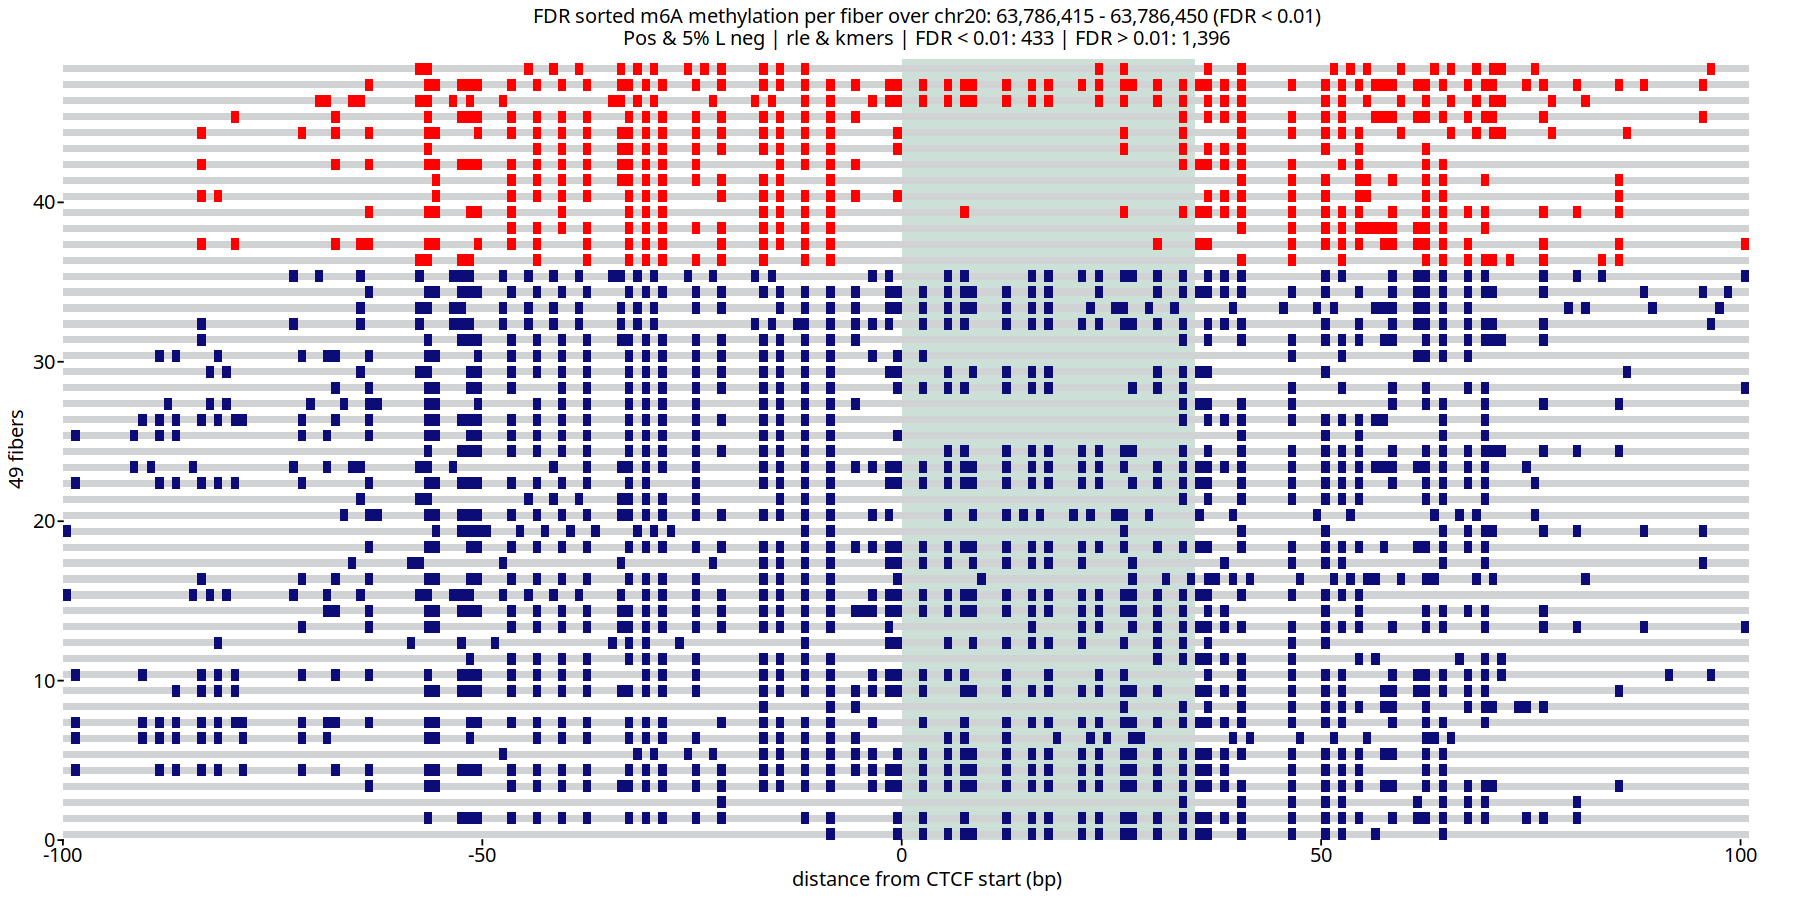

In [ ]:
if (save_pdf == TRUE) {set_plot_dimensions(pdf_dims[1], pdf_dims[2])} else {set_plot_dimensions(15, 7.5)}

# make background fiber smaller than m6a mark
squish_fiber <- 0.15

# plot (colored by FDR)
p <- ggplot(df_p) +
        # add box over motif location
        annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.2, fill=motif_annot_col) +
        geom_rect(aes(xmin=-100, xmax=101, ymin=(y_min+squish_fiber), ymax=(y_max-squish_fiber)), fill=fiber_col, data=df_p) +
        geom_rect(aes(xmin=centered_start, xmax=centered_end, ymin=y_min, ymax=y_max, group=FDR_group), fill=df_p$fill_col, data=df_p) +
        scale_fill_identity(guide="legend", labels=c("FDR low", "FDR high")) +

        ggtitle(plot_title) +
        scale_y_continuous(limits=c(0, 49), expand=expansion(add=c(0,0)), name=y_axis_name) +
        scale_x_continuous(name=x_axis_name, expand=expansion(add=c(0, 5))) +
        theme_classic() +
            theme(text = font_info,
            axis.ticks = element_line(color="#000000", lineend="square"),
            axis.text = font_info,
            axis.line = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(family="ArialMT", size=12, hjust=0.5))
p

if (save_pdf == TRUE) {
    ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])
}

#### FDR < 0.001

In [ ]:
#------------ Set output file ------------
FDR <- 0.001
output_file_name <- sprintf("CTCF_%s.mokapot.m6a_per_fiber_FDR_%s.pdf", file_root, FDR)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- FALSE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.m6a_per_fiber_FDR_0.001.pdf"


In [ ]:
# make plotting data
df_p <- moka[, c("motif_query", "motif_name", "query_name", "centered_start", "centered_end", "FDR")]
     

In [ ]:
# sort by FDR value (plotting in reverse order for some reason)
df_p <- df_p[order(df_p$FDR, decreasing=TRUE)]

# add col with y-axis coords
y_min <- seq(from=0, by=1, length.out=length(unique(df_p$query_name)))
y_max <- seq(from=0.75, by=1, length.out=length(unique(df_p$query_name)))

y_min_vals <- setNames(y_min, unique(df_p$query_name))
y_max_vals <- setNames(y_max, unique(df_p$query_name))

df_p <- df_p %>%
            mutate(
                y_min = y_min_vals[query_name],
                y_max = y_max_vals[query_name]
            )

# get plot limits
x_min <- max(df_p$centered_start)
x_max <- min(df_p$centered_end)
# number of fibers
n_fibers <- length(unique(df_p$query_name))


In [ ]:
# make plot & axes titles
y_limits <- c(0, NA)
x_limits <- c(-100, 100)
plot_title <- sprintf("FDR sorted m6A methylation per fiber over %s: %s-%s (FDR < %s)\n%s | rle & kmers | FDR < %s: %s | FDR > %s: %s", 
                      motif_coords[1],
                      format(motif_coords[2], big.mark=",", scientific=FALSE),
                      format(motif_coords[3], big.mark=",", scientific=FALSE),
                      FDR, "Pos & 5% L neg", FDR,
                      format(table(df_p$FDR_group)["low_FDR"], big.mark=",", scientific=FALSE), FDR,
                      format(table(df_p$FDR_group)["high_FDR"], big.mark=",", scientific=FALSE))
x_axis_name <- "distance from CTCF start (bp)"
y_axis_name <- sprintf("%s fibers", length(unique(df_p$query_name)))
#legend_labels <- c(sprintf("FDR > %s", FDR), sprintf("FDR < %s", FDR))

In [ ]:
# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")
# neg, high m6A & no TF: blue | pos, no m6A & TF: red
color_vals <- c(mitch_cols[2], mitch_cols[5])

# add color based on FDR value
df_p$fill_col <- ifelse(df_p$FDR <= FDR, color_vals[1], color_vals[2])
df_p$FDR_group <- ifelse(df_p$FDR <= FDR, "low_FDR", "high_FDR")

In [ ]:
# set plot parameters
plot_title <- sprintf("(%s) m6a instances per fiber (%s) over %s: %s-%s\nFDR < %s",
                      "Pos & 5% L neg", length(unique(df_p$query_name)), motif_coords[1], motif_coords[2], motif_coords[3], FDR)
x_axis_name <- "area surrounding motif (bp)"
y_axis_name <- sprintf("%s fibers", length(unique(df_p$query_name)))
font_size <- 10
font_info <- element_text(size=font_size, family="ArialMT", color="black")

# grey
vline_col <- "#CECDCC"
# purple
m6a_col <- "#7F3F98"
# gray
fiber_col <- "#D1D2D4"

# colors from Mitchell's presentation
# orange, red, purple, light grey, navy (gene track)
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")

In [ ]:
# add color based on FDR value
# purple, red
fill_cols <- c(m6a_col, mitch_cols[2])

df_p$fill_col <- ifelse(df_p$FDR <= FDR, fill_cols[1], fill_cols[2])
df_p$FDR_group <- ifelse(df_p$FDR <= FDR, "low_FDR", "high_FDR")

In [ ]:
# change plot dimensions
options(repr.plot.width=20, repr.plot.height=10)

set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }

set_plot_dimensions(12, 6)

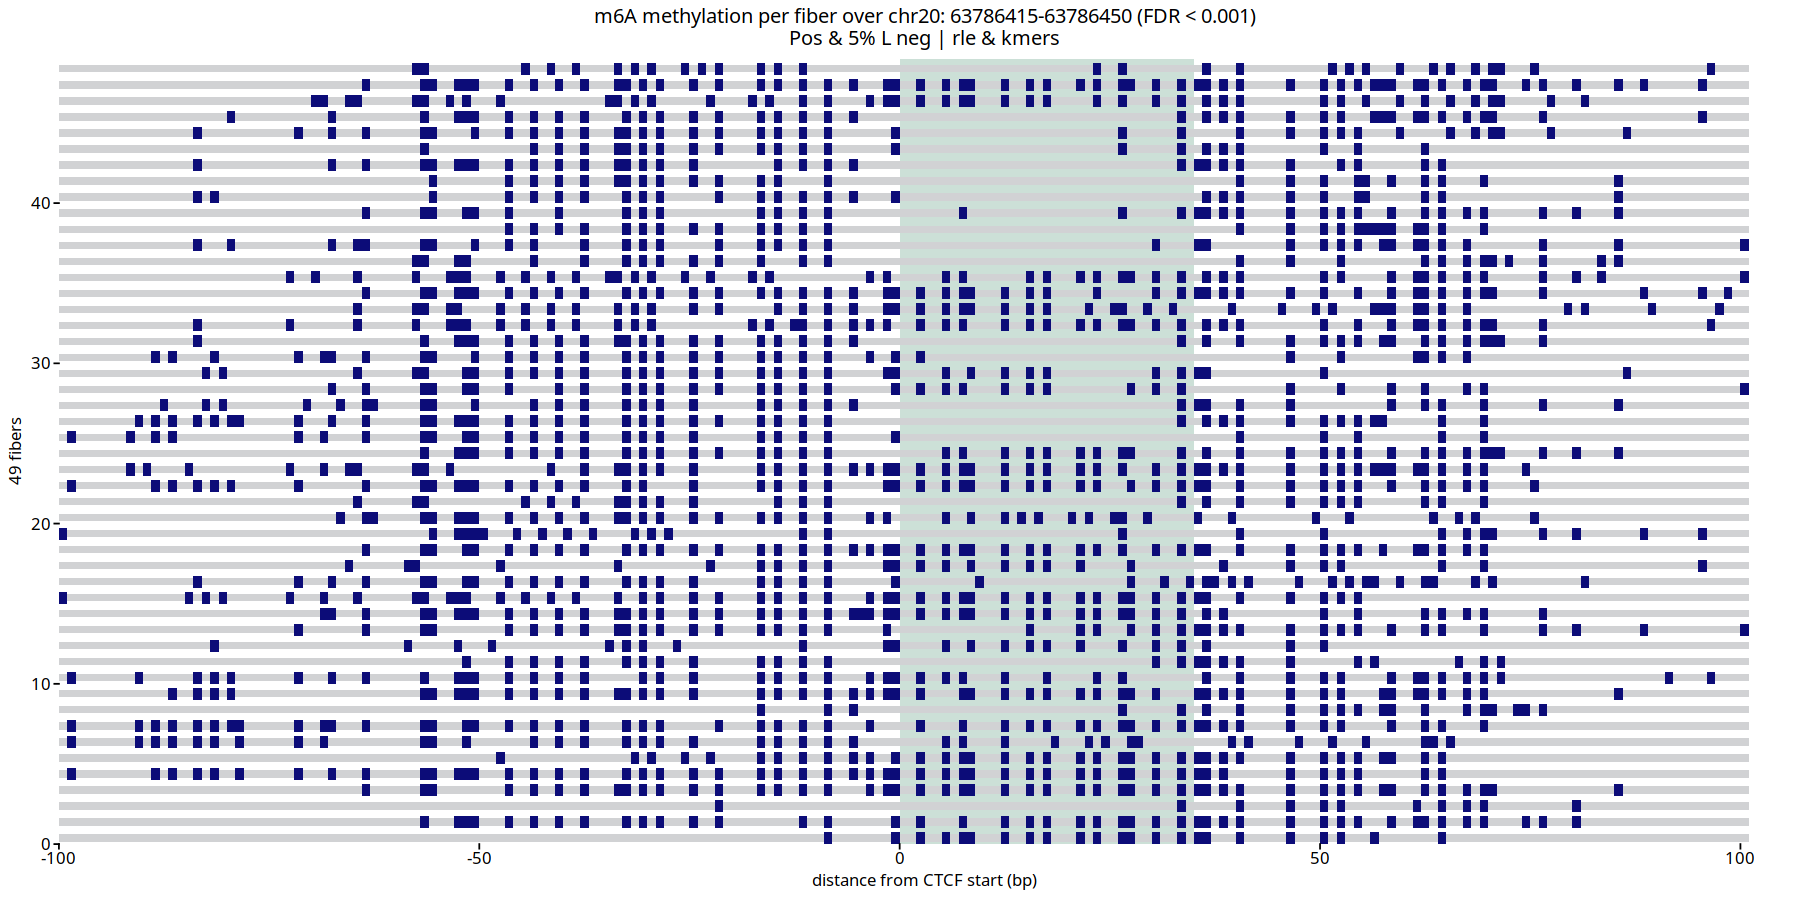

In [ ]:
if (save_pdf == TRUE) {set_plot_dimensions(pdf_dims[1], pdf_dims[2])} else {set_plot_dimensions(15, 7.5)}

# make background fiber smaller than m6a mark
squish_fiber <- 0.15

# plot (colored by FDR)
p <- ggplot(df_p) +
        # add box over motif location
        annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.2, fill=motif_annot_col) +
        geom_rect(aes(xmin=-100, xmax=101, ymin=(y_min+squish_fiber), ymax=(y_max-squish_fiber)), fill=fiber_col, data=df_p) +
        geom_rect(aes(xmin=centered_start, xmax=centered_end, ymin=y_min, ymax=y_max, group=FDR_group, fill=fill_col), fill=df_p$fill_col, data=df_p) +
        scale_color_identity() +

        ggtitle(plot_title) +
        scale_y_continuous(limits=c(0, 49), expand=expansion(add=c(0,0)), name=y_axis_name) +
        scale_x_continuous(name=x_axis_name, expand=expansion(add=c(0, 5))) +
        theme_classic() +
        theme(text = font_info,
            axis.ticks = element_line(color="#000000", lineend="square"),
            axis.text = font_info,
            axis.line = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(family="ArialMT", size=12, hjust=0.5))#,
            #legend.position = "none")
p

if (save_pdf == TRUE) {ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])}

## plot rle histogram

In [ ]:
#------------ Set output file ------------
output_file_name <- sprintf("CTCF_%s.mokapot.positive_rle_bin_count.pdf", file_root)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- FALSE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.positive_rle_bin_count.pdf"


In [98]:
# set args
feature_dir <- sprintf("%s/feature_data", getwd())
motif_type <- "L"
input_file_root <- "rle-v3"
file_root <- "100bp_L_rle_all" # for output file & titles
ctcf_dist <- c(-100,100)
n_rows <- Inf

# load set data file
data_file_name <- sprintf("CTCF_m6a_fiberseq_L_100bp_positive_features-%s.txt", input_file_root)
data_file <- sprintf("%s/%s", feature_dir, data_file_name)
print(data_file)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/feature_data/CTCF_m6a_fiberseq_L_100bp_positive_features-rle-v3.txt"


In [100]:
# read table
df <- fread(data_file, nrows=n_rows)
sprintf("feature rows: %s", format(dim(df)[1], big.mark=",", scientific=FALSE))

[1] "feature rows: 238,348"

In [202]:
# read example table
df_ex <- fread(sprintf("%s/CTCF_m6a_fiberseq_100bp_fig_example_positive.txt", data_folder))
dim(df_ex)

[1] 2165   13

In [203]:
# get only m6a rows (within an MSP)
df_ex <- filter(df_ex, centered_position_type %in% c("m6a"))
dim(df_ex)

[1] 1997   13

In [206]:
# add motif_name row
df_ex$motif_name <- paste(df_ex$chrom, df_ex$centering_position, df_ex$strand, sep="_")
# move motif_name to first column
df_ex <- df_ex %>%
    select("motif_name", everything())

# add motif_query column
df_Ex <- cbind(paste(df_ex$motif_name, df_ex$query_name, sep="/"), df_ex)
# rename column
colnames(df_ex)[1] = "motif_query"

In [229]:
df_ex %>%
    filter(!(grepl("N", subset_sequence)))

ERROR: Error in filter(., !(grepl("N", subset_sequence))): object 'df_ex' not found


In [209]:
dim(df_ex)
head(df_ex, 3)

[1] 1997   14

motif_query,chrom,centering_position,strand,subset_sequence,reference_start,reference_end,query_name,centered_query_start,centered_query_end,query_length,centered_position_type,centered_start,centered_end
<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>
chr20_63786415_+,chr20,63786415,+,CAACTGCTAATGTCTGGAGACATTTTTGGTTGTACCAACGGGGATCCAAAGGCAGGTGCTCCTGGCATCTGTGGGTGGAGGCCACAGCTGCTGCTAACATCCTGCAGTACCCAGACAGCCTCACGATGGAGCACAACTCAGCCCGAGGCTGAGTTAAACCAACTGCTGTTTTTTGTTTGTTTTGAGGTTTTTTGATTTGTT,63768587,63788702,m54329U_210326_192251/159909932/ccs,-17696,2294,19990,m6a,-67,-66
chr20_63786415_+,chr20,63786415,+,CAACTGCTAATGTCTGGAGACATTTTTGGTTGTACCAACGGGGATCCAAAGGCAGGTGCTCCTGGCATCTGTGGGTGGAGGCCACAGCTGCTGCTAACATCCTGCAGTACCCAGACAGCCTCACGATGGAGCACAACTCAGCCCGAGGCTGAGTTAAACCAACTGCTGTTTTTTGTTTGTTTTGAGGTTTTTTGATTTGTT,63768587,63788702,m54329U_210326_192251/159909932/ccs,-17696,2294,19990,m6a,-64,-63
chr20_63786415_+,chr20,63786415,+,CAACTGCTAATGTCTGGAGACATTTTTGGTTGTACCAACGGGGATCCAAAGGCAGGTGCTCCTGGCATCTGTGGGTGGAGGCCACAGCTGCTGCTAACATCCTGCAGTACCCAGACAGCCTCACGATGGAGCACAACTCAGCCCGAGGCTGAGTTAAACCAACTGCTGTTTTTTGTTTGTTTTGAGGTTTTTTGATTTGTT,63768587,63788702,m54329U_210326_192251/159909932/ccs,-17696,2294,19990,m6a,-63,-62


In [103]:
# get rle columns
rle_cols <- colnames(df)[str_detect(colnames(df), "rle")]

# filter for rle cols
d <- df %>% select(all_of(rle_cols))

In [ ]:
head(d, 2)

rle_0,rle_1,rle_2,rle_3,rle_4,rle_5,rle_6,rle_7,rle_8,rle_9,⋯,rle_26,rle_27,rle_28,rle_29,rle_30,rle_31,rle_32,rle_33,rle_34,rle_35
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [104]:
col_sums <- colSums(d)
col_sums

rle_0  rle_1  rle_2  rle_3  rle_4  rle_5  rle_6  rle_7  rle_8  rle_9 rle_10 
860117 213358  71975  33632  18808  11806   9377   8368   7626   8011   8598 
rle_11 rle_12 rle_13 rle_14 rle_15 rle_16 rle_17 rle_18 rle_19 rle_20 rle_21 
  8668   9159   9493   8525   8403   7284   6091   4983   4018   2558   1823 
rle_22 rle_23 rle_24 rle_25 rle_26 rle_27 rle_28 rle_29 rle_30 rle_31 rle_32 
  1060    483    194      2      0      0      0      0      0      0      0 
rle_33 rle_34 rle_35 
     0      0      0

In [105]:
col_names <- names(d)

In [106]:
col_names <- names(d)
rle_counts <- c()
for (i in seq_along(names(d))) {
    rle_counts <- c(rle_counts, rep(i-1, each=col_sums[col_names[i]]))
}

In [ ]:
df_rle <- data.frame(rle_counts)
dim(df_rle)
names(df_rle)

[1] 1324420       1

[1] "rle_counts"

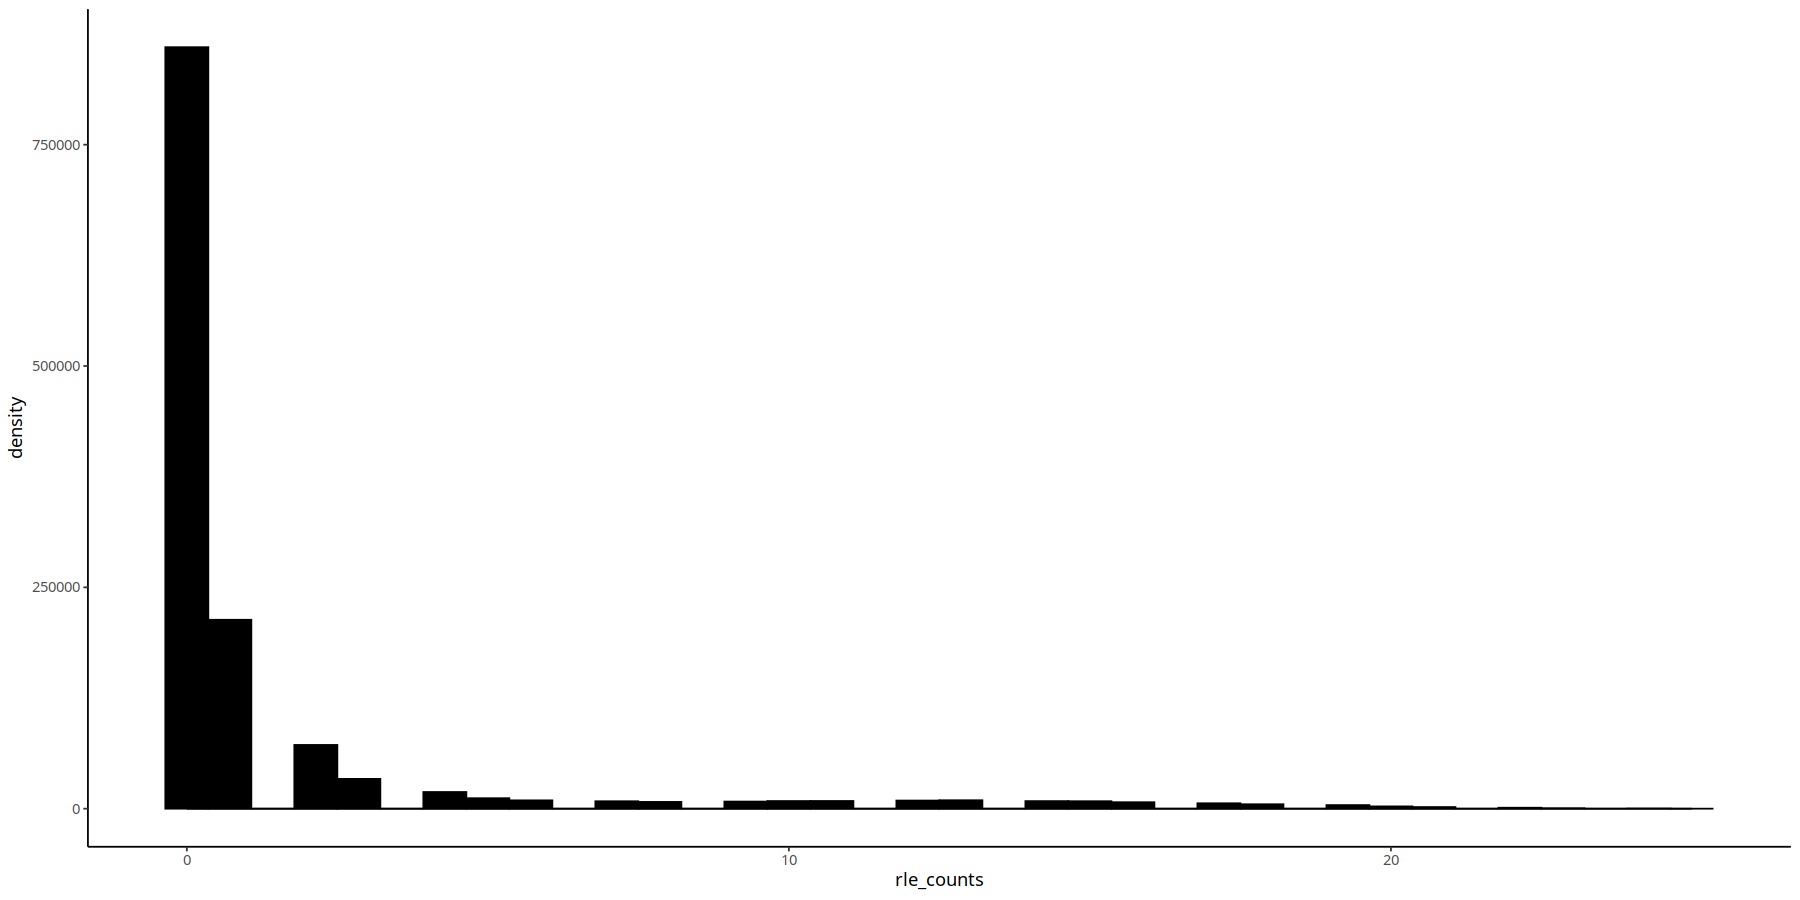

In [ ]:
ggplot(df_rle, aes(x=rle_counts)) + 
    geom_histogram(bins=36, colour="black", fill="black") +
    geom_density(alpha=.2, fill="#FF6666") +
    theme_classic()

[1] 238348

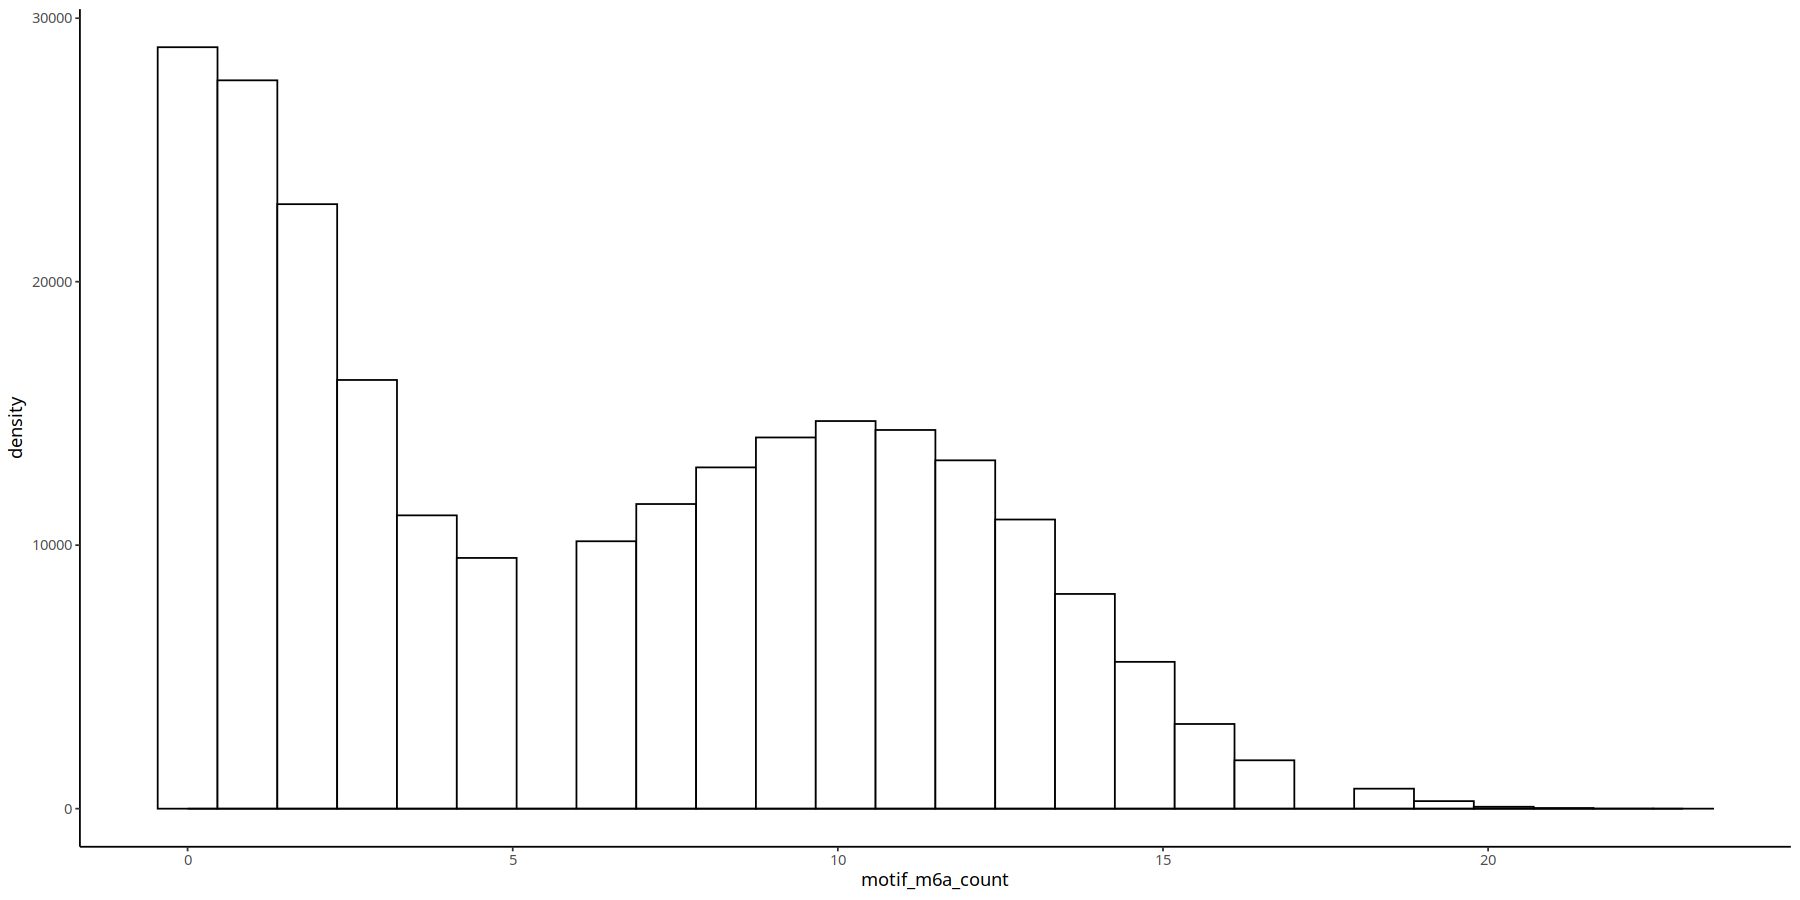

In [182]:
nrow(df[,"motif_m6a_count"])
ggplot(df[,"motif_m6a_count"], aes(x=motif_m6a_count)) +
    geom_histogram(bins=26, color="black", fill="white") +
    geom_density(fill="#FF6666") +
    theme_classic()

In [107]:
head(d)

rle_0,rle_1,rle_2,rle_3,rle_4,rle_5,rle_6,rle_7,rle_8,rle_9,⋯,rle_26,rle_27,rle_28,rle_29,rle_30,rle_31,rle_32,rle_33,rle_34,rle_35
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,0,1,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0


In [162]:
d$max_rle <- apply(d, 1, function(x) (if (max(x) == 0) {0} else {max(which(x > 0))-1}))

In [188]:
table(df[,"motif_m6a_count"])

motif_m6a_count
    0     1     2     3     4     5     6     7     8     9    10    11    12 
28899 27642 22942 16270 11132  9516 10149 11562 12952 14088 14711 14372 13220 
   13    14    15    16    17    18    19    20    21    22    23 
10974  8149  5572  3214  1836   759   287    73    25     3     1 

In [191]:
tblFun <- function(x){
    #Get count & percentage of df col values.
    tbl <- table(x)
    res <- cbind(tbl,round(prop.table(tbl)*100,2))
    colnames(res) <- c('Count','Percentage')
    res
}

do.call(rbind,lapply(df[,"motif_m6a_count"], tblFun))

,Count,Percentage
0,28899,12.12
1,27642,11.60
2,22942,9.63
3,16270,6.83
4,11132,4.67
5,9516,3.99
6,10149,4.26
7,11562,4.85
8,12952,5.43
9,14088,5.91


In [194]:
head(df, 2)

motif_query,motif_name,query_name,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,⋯,rle_26,rle_27,rle_28,rle_29,rle_30,rle_31,rle_32,rle_33,rle_34,rle_35
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr10_100338605_+/m54329U_210323_190418/12585455/ccs,chr10_100338605_+,m54329U_210323_190418/12585455/ccs,200,13,13,3,18,18,13,⋯,0,0,0,0,0,0,0,0,0,0
chr10_100338605_+/m54329U_210323_190418/16515087/ccs,chr10_100338605_+,m54329U_210323_190418/16515087/ccs,212,12,12,4,18,18,13,⋯,0,0,0,0,0,0,0,0,0,0


In [196]:
length(unique(df$motif_name))
length(unique(df$query_name))
length(unique(df$motif_query))

[1] 6504

[1] 223211

[1] 238348

In [193]:
do.call(rbind, lapply(d[,"max_rle"], tblFun))

,Count,Percentage
0,15056,6.32
1,40295,16.91
2,28968,12.15
3,18886,7.92
4,12970,5.44
5,9280,3.89
6,8278,3.47
7,7853,3.29
8,7482,3.14
9,7957,3.34


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


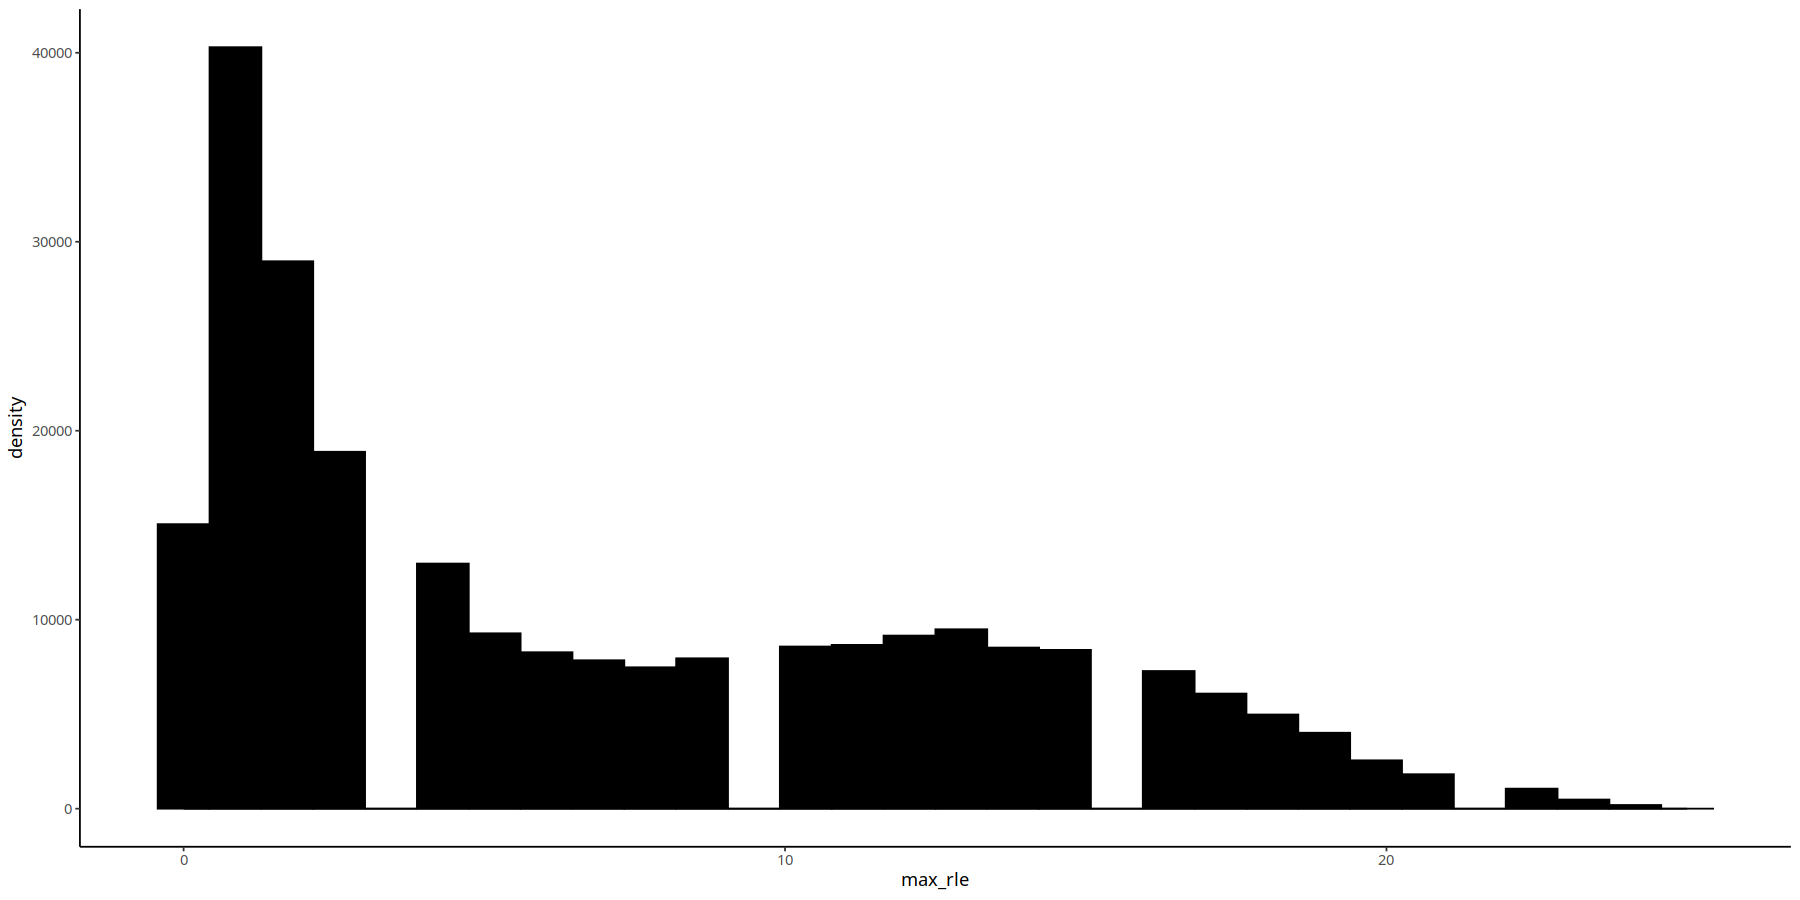

In [165]:
ggplot(d, aes(x=max_rle)) + 
    geom_histogram(colour="black", fill="black") +
    geom_density(alpha=.2, fill="#FF6666") +
    theme_classic()